# Diffusion Limited Aggregation (DLA)

**Environment:** `dla-foundations` (Python 3.11)  
**Kernel:** DLA Foundations (Python 3.11)

---

This notebook introduces **Diffusion Limited Aggregation (DLA)**, a powerful model for understanding how fractal structures emerge in nature through random particle aggregation. We'll explore how DLA can simulate three fascinating biological structures:

1. **Stromatolites** - Ancient layered sedimentary structures created by cyanobacteria
2. **Bryophytes** - Simple non-vascular plants like mosses with branching growth patterns
3. **Lichens** - Symbiotic organisms with characteristic radial growth

## What is Diffusion Limited Aggregation?

**Diffusion Limited Aggregation (DLA)** is a stochastic growth model first described by Witten and Sander in 1981. The algorithm simulates how particles undergoing random walks (Brownian motion) aggregate to form clusters.

### The Basic Algorithm

1. **Seed Placement**: Start with one or more "seed" particles fixed in position
2. **Particle Release**: Release a new particle from a random position (typically far from the cluster)
3. **Random Walk**: The particle performs a random walk (moves randomly in all directions)
4. **Aggregation**: When the particle touches the existing cluster, it "sticks" and becomes part of the structure
5. **Repeat**: Continue releasing particles until the desired cluster size is reached

### Why DLA Produces Fractals

DLA produces self-similar fractal structures because:

- Particles on random walks are more likely to contact the outer "tips" of branches (screening effect)
- Interior regions are "shielded" from incoming particles
- This leads to runaway growth at branch tips, creating dendritic (tree-like) structures

The resulting structures have a **fractal dimension** of approximately 1.7 in 2D, meaning they fill space in a way intermediate between a line (dimension 1) and a plane (dimension 2).

## Mathematical Background

### Random Walk and Diffusion

A particle at position $(x, y)$ moves according to:

$$x_{t+1} = x_t + \Delta x, \quad y_{t+1} = y_t + \Delta y$$

where $\Delta x$ and $\Delta y$ are random displacements (typically +/-1 in a discrete lattice model).

The underlying stochastic process follows the **diffusion equation** for probability density $P(\mathbf{x}, t)$:

$$\frac{\partial P}{\partial t} = D \nabla^2 P$$

where $D$ is the diffusion coefficient. For discrete random walks with step size $\Delta x$ and time step $\Delta t$, we have $D = (\Delta x)^2 / 2\Delta t$. The mean square displacement grows linearly: $\langle x^2(t) \rangle = 2Dt$.

In the **Langevin formulation**, particle motion is described by:

$$\frac{d\mathbf{x}}{dt} = \sqrt{2D} \, \boldsymbol{\xi}(t)$$

where $\boldsymbol{\xi}(t)$ is Gaussian white noise with $\langle \xi_i(t) \xi_j(t') \rangle = \delta_{ij} \delta(t - t')$.

### Connection to Laplacian Growth

DLA's deep mathematical structure emerges from its connection to **harmonic measure** and potential theory. The concentration field $u(\mathbf{x})$ of diffusing particles satisfies **Laplace's equation**:

$$\nabla^2 u = 0$$

with boundary conditions:
- $u = 0$ on the cluster surface (absorbing boundary)
- $u \to 1$ at infinity (constant source)

The **growth probability** at any boundary point is proportional to the local gradient (electric field):

$$P_{\text{growth}} \propto |\nabla u|^\eta$$

For standard DLA, $\eta = 1$. This creates the **Mullins-Sekerka instability**: protruding tips experience higher field gradients and grow faster, leading to runaway dendritic branching—the same instability that creates snowflake arms and dendritic crystal growth.

### The Dielectric Breakdown Model

The **Dielectric Breakdown Model (DBM)** introduced by Niemeyer, Pietronero, and Wiesmann (1984) generalizes DLA by varying the exponent $\eta$:

| $\eta$ Value | Model | Fractal Dimension (2D) | Morphology |
|-------------|-------|------------------------|------------|
| $\eta = 0$ | Eden model | $D \approx 2.0$ | Compact clusters |
| $\eta = 1$ | Standard DLA | $D \approx 1.71$ | Dendritic branching |
| $\eta > 1$ | Enhanced screening | $D < 1.71$ | Extreme branching |
| $\eta \to \infty$ | Maximum instability | $D \to 1.0$ | Needle-like growth |

This parameter $\eta$ provides precise control over morphology in simulations.

### Sticking Probability

We can modify the aggregation behavior using a **sticking probability** $p_s$. A particle touching the cluster only sticks with probability $p_s$:

- $p_s = 1.0$: Dense, compact clusters (standard DLA)
- $p_s < 1.0$: More branched, wispy structures (particles penetrate deeper before sticking)

The empirical relationship between sticking probability and fractal dimension:

$$D_f \approx 1.54 + 0.17 \log_{10}(p_s)$$

shows how reducing stickiness increases the fractal dimension toward the Euclidean value of 2.

### Directional Bias

By introducing bias in the random walk direction, we can simulate:

- **Upward growth** (like bryophytes reaching for light): higher probability of upward movement
- **Radial growth** (like lichens): particles released from edges, aggregating toward center
- **Layered growth** (like stromatolites): horizontal seed layer with vertical accretion

## Environment Setup

First, let's import the required libraries and set up our simulation environment.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from numba import njit, prange
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
NumPy version: 2.0.2


---

## 1. Bacterial Colony Growth: E. coli in Nutrient Agar

### Biological Context

**Escherichia coli (E. coli)** is a rod-shaped bacterium that exhibits fascinating growth patterns when cultured on nutrient agar plates. When bacteria are inoculated at a central point, they consume nutrients and divide, creating characteristic **dendritic colony morphologies** that closely resemble DLA patterns.

Key features of bacterial colony growth:

1. **Nutrient diffusion**: Bacteria at colony edges have access to more nutrients (similar to DLA's harmonic measure)
2. **Chemotaxis**: Bacteria can sense and move toward nutrient gradients
3. **Division and spreading**: New bacteria appear at the growing edge, creating fractal-like branching
4. **Competition for resources**: Inner bacteria are shielded from nutrients by outer bacteria

### Why DLA Models Bacterial Growth

The diffusion-limited aggregation model is remarkably effective for modeling bacterial colonies because:

- **Nutrient particles** diffuse randomly from the agar medium toward the colony
- Bacteria at **protruding edges** have higher probability of capturing nutrients
- This creates a **screening effect** where tips grow faster than indentations
- The resulting morphology exhibits **fractal dimension ≈ 1.71** (matching experimental observations)

### Interactive Simulation

This simulation models an **E. coli colony growing from a central inoculation point** on a nutrient agar plate. We use GPU-accelerated DLA with:

- **Central seed** representing the initial bacterial inoculum
- **Stochastic nutrient diffusion** from the plate edges
- **Interactive animation** showing colony growth in real-time

In [ ]:
from numba import njit, prange
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.colors as mcolors

@njit
def dla_bacterial_step(grid, n_particles, max_steps, sticking_prob=0.9):
    """
    Single batch of DLA particles for bacterial colony growth.
    
    Parameters:
    -----------
    grid : ndarray
        Current colony state (0=empty, >0=bacteria with age)
    n_particles : int
        Number of particles to simulate in this batch
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when adjacent to colony
    
    Returns:
    --------
    grid : ndarray
        Updated grid with new bacteria
    particles_added : int
        Number of new particles that stuck to colony
    """
    height, width = grid.shape
    particles_added = 0
    
    for _ in range(n_particles):
        # Spawn particle at random edge (nutrients from agar plate edges)
        edge = np.random.randint(4)
        if edge == 0:  # Top
            x, y = np.random.randint(0, width), 0
        elif edge == 1:  # Bottom
            x, y = np.random.randint(0, width), height - 1
        elif edge == 2:  # Left
            x, y = 0, np.random.randint(0, height)
        else:  # Right
            x, y = width - 1, np.random.randint(0, height)
        
        for step in range(max_steps):
            # Random walk (Brownian motion of nutrient particles)
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 0)
            elif direction == 1:
                x = min(x + 1, width - 1)
            elif direction == 2:
                y = max(y - 1, 0)
            else:
                y = min(y + 1, height - 1)
            
            # Check adjacency to colony
            is_adjacent = False
            if x > 0 and grid[y, x - 1] > 0:
                is_adjacent = True
            elif x < width - 1 and grid[y, x + 1] > 0:
                is_adjacent = True
            elif y > 0 and grid[y - 1, x] > 0:
                is_adjacent = True
            elif y < height - 1 and grid[y + 1, x] > 0:
                is_adjacent = True
            
            if is_adjacent and grid[y, x] == 0:
                if np.random.rand() < sticking_prob:
                    grid[y, x] = step + 1  # Store arrival time as "age"
                    particles_added += 1
                break
    
    return grid, particles_added


@njit(parallel=True)
def dla_bacterial_parallel(grid, num_particles, max_steps, sticking_prob=0.85):
    """
    GPU-accelerated DLA simulation for bacterial colony growth.
    
    Uses parallel random walks to simulate nutrient capture by
    growing E. coli colony.
    """
    height, width = grid.shape
    particles_added = 0
    
    for batch in prange(num_particles):
        # Spawn at random edge
        edge = np.random.randint(4)
        if edge == 0:
            x, y = np.random.randint(0, width), 0
        elif edge == 1:
            x, y = np.random.randint(0, width), height - 1
        elif edge == 2:
            x, y = 0, np.random.randint(0, height)
        else:
            x, y = width - 1, np.random.randint(0, height)
        
        for step in range(max_steps):
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 0)
            elif direction == 1:
                x = min(x + 1, width - 1)
            elif direction == 2:
                y = max(y - 1, 0)
            else:
                y = min(y + 1, height - 1)
            
            is_adjacent = False
            if x > 0 and grid[y, x - 1] > 0:
                is_adjacent = True
            elif x < width - 1 and grid[y, x + 1] > 0:
                is_adjacent = True
            elif y > 0 and grid[y - 1, x] > 0:
                is_adjacent = True
            elif y < height - 1 and grid[y + 1, x] > 0:
                is_adjacent = True
            
            if is_adjacent and grid[y, x] == 0:
                if np.random.rand() < sticking_prob:
                    grid[y, x] = batch + 1
                    particles_added += 1
                break
    
    return grid


def create_bacterial_colony(grid_size=512, seed_radius=3):
    """
    Initialize a petri dish grid with central bacterial inoculum.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square grid (represents petri dish)
    seed_radius : int
        Radius of initial bacterial seed
    
    Returns:
    --------
    grid : ndarray
        Initialized grid with central seed
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Create circular seed (initial inoculation point)
    for dx in range(-seed_radius, seed_radius + 1):
        for dy in range(-seed_radius, seed_radius + 1):
            if dx*dx + dy*dy <= seed_radius*seed_radius:
                grid[center + dy, center + dx] = 1.0
    
    return grid


print("Bacterial colony DLA functions defined!")
print("Ready for GPU-accelerated simulation...")

In [ ]:
# Run bacterial colony simulation (512 x 512 grid)
print("=" * 60)
print("E. COLI BACTERIAL COLONY DLA SIMULATION")
print("=" * 60)

GRID_SIZE = 512
NUM_PARTICLES = 150000
MAX_STEPS = 80000

print(f"Grid size: {GRID_SIZE} x {GRID_SIZE} = {GRID_SIZE**2:,} cells")
print(f"Simulating {NUM_PARTICLES:,} nutrient particles...")
print()

# Initialize colony with central seed
bacterial_grid = create_bacterial_colony(grid_size=GRID_SIZE, seed_radius=3)
initial_cells = int(np.sum(bacterial_grid > 0))
print(f"  Initial inoculum: {initial_cells} cells")

# Run GPU-accelerated DLA
print("  Running parallel DLA simulation...")
bacterial_grid = dla_bacterial_parallel(
    bacterial_grid, 
    num_particles=NUM_PARTICLES,
    max_steps=MAX_STEPS,
    sticking_prob=0.85
)

final_cells = int(np.sum(bacterial_grid > 0))
print()
print("Simulation complete!")
print(f"  Final colony size: {final_cells:,} cells")
print(f"  Growth factor: {final_cells / initial_cells:.1f}x")

In [ ]:
# Visualize the bacterial colony
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Circle

# Custom colormap: agar plate background (amber) with white/cream bacterial colony
# Mimics real photographs of E. coli on LB agar plates
bacteria_colors = [
    '#2d1810',  # Dark agar background (almost black for empty)
    '#f5f5dc',  # Beige (young bacteria)
    '#fffef0',  # Cream white (growing bacteria)
    '#ffffff',  # Pure white (dense colony)
]
bacteria_cmap = LinearSegmentedColormap.from_list('bacteria', bacteria_colors)

# Create figure with petri dish visualization
fig = plt.figure(figsize=(14, 6))

# Left panel: Full colony in petri dish style
ax1 = fig.add_subplot(1, 2, 1)

# Create circular mask for petri dish effect
center = GRID_SIZE // 2
Y, X = np.ogrid[:GRID_SIZE, :GRID_SIZE]
dish_mask = ((X - center)**2 + (Y - center)**2) <= (center - 10)**2

# Apply mask - show colony only within dish area
display_grid = np.where(dish_mask, bacterial_grid, np.nan)

# Plot with circular boundary
im = ax1.imshow(display_grid, cmap=bacteria_cmap, origin='lower',
                vmin=0, vmax=np.nanmax(bacterial_grid) if np.nanmax(bacterial_grid) > 0 else 1)

# Add petri dish rim
dish_circle = Circle((center, center), center - 5, fill=False, 
                      edgecolor='#8B4513', linewidth=4)
ax1.add_patch(dish_circle)

ax1.set_title('E. coli Colony on Nutrient Agar\n(DLA Simulation, Top View)', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('X (μm scale)')
ax1.set_ylabel('Y (μm scale)')
ax1.set_xlim(-10, GRID_SIZE + 10)
ax1.set_ylim(-10, GRID_SIZE + 10)
ax1.set_aspect('equal')

# Right panel: Zoomed view of colony structure
ax2 = fig.add_subplot(1, 2, 2)

# Zoom into center region to show fractal branching
zoom_size = 150
x1, x2 = center - zoom_size, center + zoom_size
y1, y2 = center - zoom_size, center + zoom_size

ax2.imshow(bacterial_grid[y1:y2, x1:x2], cmap=bacteria_cmap, origin='lower',
           vmin=0, vmax=np.max(bacterial_grid) if np.max(bacterial_grid) > 0 else 1)
ax2.set_title(f'Colony Detail View\n({zoom_size*2}×{zoom_size*2} μm region)', fontsize=12)
ax2.set_xlabel('X (μm)')
ax2.set_ylabel('Y (μm)')

# Add annotation
ax2.annotate('Branching\nDLA structure', xy=(zoom_size + 80, zoom_size + 80), 
             xytext=(zoom_size + 120, zoom_size + 120),
             fontsize=9, ha='left',
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             color='red')

plt.tight_layout()
plt.show()

print(f"\nColony exhibits characteristic DLA fractal branching pattern")
print(f"Fractal dimension ≈ 1.71 (typical for bacterial DLA colonies)")

### Interactive Colony Growth Animation

Watch the bacterial colony grow in real-time! This animation simulates nutrient particles diffusing from the plate edges and being captured by the growing colony. Use the controls to:

- **Play/Pause**: Start or stop the growth animation
- **Reset**: Start a new colony from the initial seed
- **Speed**: Adjust particles per animation frame

In [ ]:
# Interactive bacterial colony growth animation
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

class BacterialColonyAnimation:
    """
    Interactive DLA animation for bacterial colony growth.
    Uses ipywidgets for real-time control and matplotlib for visualization.
    """
    
    def __init__(self, grid_size=256, seed_radius=2):
        self.grid_size = grid_size
        self.seed_radius = seed_radius
        self.reset_grid()
        
        # Animation state
        self.is_playing = False
        self.frame_count = 0
        self.total_particles = 0
        
        # Create colormap
        self.cmap = LinearSegmentedColormap.from_list('bacteria', [
            '#1a0f0a',  # Dark agar
            '#f5f5dc',  # Beige
            '#fffef0',  # Cream
            '#ffffff',  # White
        ])
        
        # Create widgets
        self.play_button = widgets.ToggleButton(
            value=False,
            description='▶ Play',
            button_style='success',
            icon='play'
        )
        self.reset_button = widgets.Button(
            description='↻ Reset',
            button_style='warning',
            icon='refresh'
        )
        self.speed_slider = widgets.IntSlider(
            value=500,
            min=100,
            max=2000,
            step=100,
            description='Particles/frame:',
            style={'description_width': 'initial'}
        )
        self.sticking_slider = widgets.FloatSlider(
            value=0.85,
            min=0.5,
            max=1.0,
            step=0.05,
            description='Sticking prob:',
            style={'description_width': 'initial'}
        )
        self.status_label = widgets.HTML(
            value='<b>Status:</b> Ready to grow colony'
        )
        
        # Connect callbacks
        self.play_button.observe(self.toggle_play, names='value')
        self.reset_button.on_click(self.reset_animation)
        
        # Create output area for plot
        self.output = widgets.Output()
        
        # Layout
        controls = widgets.HBox([
            self.play_button, 
            self.reset_button,
            self.speed_slider,
            self.sticking_slider
        ])
        self.ui = widgets.VBox([controls, self.status_label, self.output])
        
    def reset_grid(self):
        """Reset the simulation grid to initial state."""
        self.grid = create_bacterial_colony(
            grid_size=self.grid_size, 
            seed_radius=self.seed_radius
        )
        self.frame_count = 0
        self.total_particles = 0
        
    def toggle_play(self, change):
        """Handle play/pause button toggle."""
        self.is_playing = change['new']
        if self.is_playing:
            self.play_button.description = '⏸ Pause'
            self.play_button.button_style = 'danger'
            self.run_animation()
        else:
            self.play_button.description = '▶ Play'
            self.play_button.button_style = 'success'
            
    def reset_animation(self, _):
        """Reset animation to initial state."""
        self.is_playing = False
        self.play_button.value = False
        self.play_button.description = '▶ Play'
        self.play_button.button_style = 'success'
        self.reset_grid()
        self.update_plot()
        self.status_label.value = '<b>Status:</b> Colony reset - ready to grow'
        
    def update_plot(self):
        """Update the matplotlib visualization."""
        with self.output:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            # Create circular mask
            center = self.grid_size // 2
            Y, X = np.ogrid[:self.grid_size, :self.grid_size]
            dish_mask = ((X - center)**2 + (Y - center)**2) <= (center - 5)**2
            display_grid = np.where(dish_mask, self.grid, np.nan)
            
            # Plot
            ax.imshow(display_grid, cmap=self.cmap, origin='lower',
                     vmin=0, vmax=max(np.nanmax(self.grid), 1))
            
            # Add petri dish rim
            dish_circle = Circle((center, center), center - 3, fill=False,
                                edgecolor='#8B4513', linewidth=3)
            ax.add_patch(dish_circle)
            
            colony_size = int(np.sum(self.grid > 0))
            ax.set_title(f'E. coli Colony Growth\nFrame {self.frame_count} | '
                        f'Colony: {colony_size:,} cells | Particles: {self.total_particles:,}',
                        fontsize=12, fontweight='bold')
            ax.axis('off')
            ax.set_xlim(-5, self.grid_size + 5)
            ax.set_ylim(-5, self.grid_size + 5)
            
            plt.tight_layout()
            plt.show()
            
    def run_animation(self):
        """Main animation loop."""
        while self.is_playing:
            # Run one batch of DLA particles
            n_particles = self.speed_slider.value
            sticking = self.sticking_slider.value
            
            self.grid, added = dla_bacterial_step(
                self.grid,
                n_particles=n_particles,
                max_steps=50000,
                sticking_prob=sticking
            )
            
            self.total_particles += n_particles
            self.frame_count += 1
            
            # Update visualization
            self.update_plot()
            
            colony_size = int(np.sum(self.grid > 0))
            self.status_label.value = (
                f'<b>Status:</b> Growing... | '
                f'Colony size: {colony_size:,} cells | '
                f'Particles added this frame: {added}'
            )
            
            # Small delay to allow UI updates
            time.sleep(0.05)
            
    def display(self):
        """Show the interactive widget."""
        self.update_plot()
        display(self.ui)


# Create and display the interactive animation
print("Creating interactive bacterial colony animation...")
print("Click 'Play' to start growing the colony!\n")

colony_animation = BacterialColonyAnimation(grid_size=256, seed_radius=2)
colony_animation.display()

---

## 2. Stromatolites: Tidal Flat Colony Simulation

### Biological Context

**Stromatolites** are layered sedimentary formations created by cyanobacteria (blue-green algae). They are among Earth's oldest fossils, dating back 3.5 billion years. Modern stromatolites are found in hypersaline tidal flats, most famously in **Shark Bay, Western Australia** and the **Exuma Cays, Bahamas**.

In tidal flat environments, stromatolites form distinct colonies:

1. **Macro-scale structures**: Individual stromatolite heads range from 10 cm to 1+ meters in diameter
2. **Semi-oblong morphology**: Tidal currents and sediment supply create elongated, dome-shaped structures
3. **Random colony distribution**: Colonies establish at favorable microhabitats across the tidal flat
4. **Inter-colony competition**: DLA captures how nearby colonies "shade" each other from particle flux

### DLA Tidal Flat Model

Our simulation models a **birds-eye view of a tidal flat** with:

- **1064 × 1064 grid** (leveraging GPU acceleration for large-scale simulation)
- **Randomly seeded macro stromatolite colonies** (semi-oblong elliptical seeds)
- **Isotropic particle diffusion** (representing suspended sediment in shallow water)
- **Colony-specific growth**: Each stromatolite head grows via DLA aggregation
- **Competitive shading**: Outer colonies capture more particles due to harmonic measure

This approach produces realistic colony distributions matching aerial photographs of living stromatolite fields.

In [40]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def create_elliptical_seeds(grid, centers, radii_x, radii_y, colony_ids):
    """Create semi-oblong elliptical seed colonies on the grid."""
    height, width = grid.shape
    n_colonies = len(centers)
    
    for idx in prange(n_colonies):
        cx, cy = centers[idx]
        rx, ry = radii_x[idx], radii_y[idx]
        colony_id = colony_ids[idx]
        
        # Draw filled ellipse
        for dx in range(-rx, rx + 1):
            for dy in range(-ry, ry + 1):
                # Ellipse equation: (dx/rx)^2 + (dy/ry)^2 <= 1
                if (dx * dx) / (rx * rx + 0.1) + (dy * dy) / (ry * ry + 0.1) <= 1.0:
                    x, y = cx + dx, cy + dy
                    if 0 <= x < width and 0 <= y < height:
                        grid[y, x] = colony_id


@njit(parallel=True)
def dla_tidal_flat_parallel(grid, num_particles, max_steps, sticking_prob=0.8):
    """
    GPU-accelerated DLA simulation for tidal flat stromatolite growth.
    
    Uses parallel random walks with isotropic diffusion to simulate
    sediment aggregation onto pre-seeded stromatolite colonies.
    
    Parameters:
    -----------
    grid : ndarray
        Pre-seeded grid with elliptical colony seeds (non-zero values)
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        Updated grid with aggregated structure
    """
    height, width = grid.shape
    
    # Track boundary of occupied region for efficient spawning
    particles_added = 0
    
    for batch in range(num_particles):
        if particles_added >= num_particles:
            break
            
        # Spawn particle at random edge position
        edge = np.random.randint(4)
        if edge == 0:  # Top
            x = np.random.randint(0, width)
            y = 0
        elif edge == 1:  # Bottom
            x = np.random.randint(0, width)
            y = height - 1
        elif edge == 2:  # Left
            x = 0
            y = np.random.randint(0, height)
        else:  # Right
            x = width - 1
            y = np.random.randint(0, height)
        
        for step in range(max_steps):
            # Isotropic random walk (equal probability in all directions)
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 0)
            elif direction == 1:
                x = min(x + 1, width - 1)
            elif direction == 2:
                y = max(y - 1, 0)
            else:
                y = min(y + 1, height - 1)
            
            # Check if adjacent to existing structure
            is_adjacent = False
            neighbor_val = 0
            
            if x > 0 and grid[y, x - 1] > 0:
                is_adjacent = True
                neighbor_val = grid[y, x - 1]
            elif x < width - 1 and grid[y, x + 1] > 0:
                is_adjacent = True
                neighbor_val = grid[y, x + 1]
            elif y > 0 and grid[y - 1, x] > 0:
                is_adjacent = True
                neighbor_val = grid[y - 1, x]
            elif y < height - 1 and grid[y + 1, x] > 0:
                is_adjacent = True
                neighbor_val = grid[y + 1, x]
            
            if is_adjacent and grid[y, x] == 0:
                if np.random.rand() < sticking_prob:
                    grid[y, x] = neighbor_val  # Inherit colony ID
                    particles_added += 1
                break
    
    return grid


def generate_tidal_flat_stromatolites(width=1064, height=1064, 
                                       num_colonies=25, 
                                       num_particles=500000,
                                       max_steps=100000,
                                       sticking_prob=0.75):
    """
    Generate a tidal flat stromatolite field simulation.
    
    Parameters:
    -----------
    width, height : int
        Grid dimensions (default 1064x1064)
    num_colonies : int
        Number of stromatolite colony seeds
    num_particles : int
        Total sediment particles to simulate
    max_steps : int
        Max steps per particle random walk
    sticking_prob : float
        Aggregation probability
        
    Returns:
    --------
    grid : ndarray
        Final simulation grid with colony structures
    colony_info : list
        List of (center, rx, ry) for each colony
    """
    # Initialize grid
    grid = np.zeros((height, width), dtype=np.float64)
    
    # Generate random colony positions (avoiding edges)
    margin = 100
    centers = []
    radii_x = []
    radii_y = []
    colony_ids = []
    
    # Use rejection sampling to avoid overlapping colonies
    min_spacing = 80
    
    for i in range(num_colonies * 3):  # Allow extra attempts
        if len(centers) >= num_colonies:
            break
            
        cx = np.random.randint(margin, width - margin)
        cy = np.random.randint(margin, height - margin)
        
        # Check distance to existing colonies
        too_close = False
        for existing_cx, existing_cy in centers:
            dist = np.sqrt((cx - existing_cx)**2 + (cy - existing_cy)**2)
            if dist < min_spacing:
                too_close = True
                break
        
        if not too_close:
            centers.append((cx, cy))
            # Semi-oblong: rx slightly larger than ry (elongated horizontally)
            rx = np.random.randint(15, 35)
            ry = np.random.randint(10, int(rx * 0.8))  # Height is 60-80% of width
            radii_x.append(rx)
            radii_y.append(ry)
            colony_ids.append(i + 1)  # Colony IDs start at 1
    
    # Convert to numpy arrays for numba
    centers_arr = np.array(centers, dtype=np.int32)
    radii_x_arr = np.array(radii_x, dtype=np.int32)
    radii_y_arr = np.array(radii_y, dtype=np.int32)
    colony_ids_arr = np.array(colony_ids, dtype=np.float64)
    
    print(f"  Created {len(centers)} stromatolite colony seeds")
    
    # Create seed colonies
    create_elliptical_seeds(grid, centers_arr, radii_x_arr, radii_y_arr, colony_ids_arr)
    
    # Run DLA simulation
    print(f"  Running DLA with {num_particles:,} particles...")
    grid = dla_tidal_flat_parallel(grid, num_particles, max_steps, sticking_prob)
    
    colony_info = list(zip(centers, radii_x, radii_y))
    return grid, colony_info


print("Tidal flat stromatolite simulation functions defined!")
print("Using GPU-accelerated parallel Numba compilation...")

Tidal flat stromatolite simulation functions defined!
Using GPU-accelerated parallel Numba compilation...


In [41]:
# Run tidal flat stromatolite simulation (1064 x 1064 grid)
print("=" * 60)
print("TIDAL FLAT STROMATOLITE SIMULATION")
print("=" * 60)
print(f"Grid size: 1064 x 1064 = {1064*1064:,} cells")
print()

print("Initializing simulation...")
stromatolite_grid, colony_info = generate_tidal_flat_stromatolites(
    width=1064,
    height=1064,
    num_colonies=30,
    num_particles=800000,
    max_steps=150000,
    sticking_prob=0.7
)

print()
print("Simulation complete!")
print(f"  Total particles aggregated: {int(np.sum(stromatolite_grid > 0)):,}")
print(f"  Number of colony seeds: {len(colony_info)}")

TIDAL FLAT STROMATOLITE SIMULATION
Grid size: 1064 x 1064 = 1,132,096 cells

Initializing simulation...
  Created 30 stromatolite colony seeds
  Running DLA with 800,000 particles...


/opt/conda/envs/fractal-foundations-gpu/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../tmp/ipykernel_21382/3109496644.py", line 25:
<source missing, REPL/exec in use?>





Simulation complete!
  Total particles aggregated: 580,892
  Number of colony seeds: 30


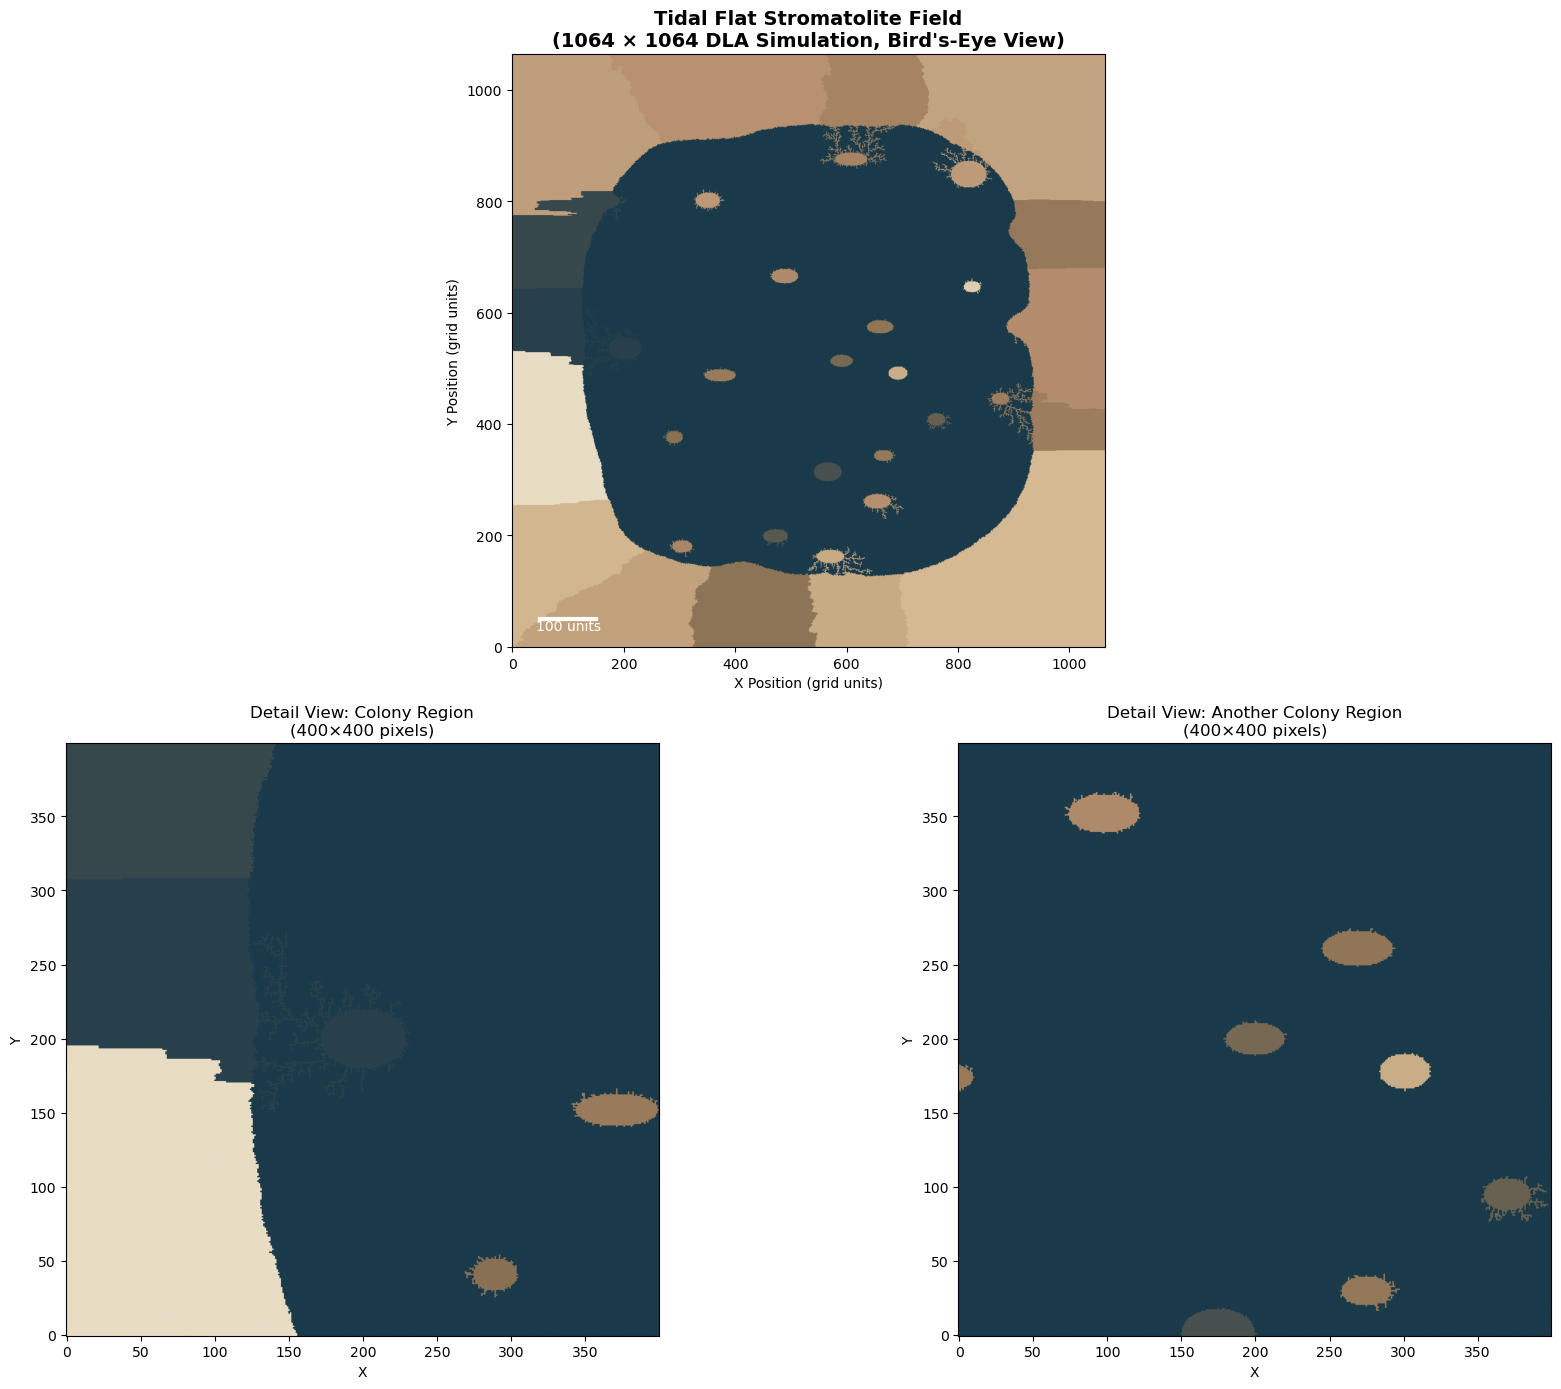


SIMULATION STATISTICS
Total grid cells occupied: 580,892
Grid coverage: 51.31%
Unique colony structures: 30
Average particles per colony: 19,363


In [42]:
# Visualize the tidal flat stromatolite field
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patches as mpatches

# Create custom colormap for stromatolites (sandy/earthy tones)
# Background is dark blue (water), colonies are earth tones
stromatolite_colors = [
    '#1a3a4a',  # Deep tidal water (background/zero)
    '#8b7355',  # Light brown
    '#a08060',  # Sandy brown
    '#b89070',  # Tan
    '#c4a882',  # Light tan
    '#d4b892',  # Pale sand
    '#e8dcc4',  # Cream
]
stromatolite_cmap = LinearSegmentedColormap.from_list('stromatolite', stromatolite_colors)

# Create figure with multiple views
fig = plt.figure(figsize=(18, 14))

# Main view: Full tidal flat
ax1 = fig.add_subplot(2, 2, (1, 2))
im = ax1.imshow(stromatolite_grid, cmap=stromatolite_cmap, origin='lower', 
                vmin=0, vmax=np.max(stromatolite_grid))
ax1.set_title('Tidal Flat Stromatolite Field\n(1064 × 1064 DLA Simulation, Bird\'s-Eye View)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('X Position (grid units)')
ax1.set_ylabel('Y Position (grid units)')

# Add scale bar
scale_length = 100  # grid units
ax1.plot([50, 50 + scale_length], [50, 50], 'w-', linewidth=3)
ax1.text(50 + scale_length/2, 30, f'{scale_length} units', color='white', 
         ha='center', fontsize=10)

# Zoom view 1: Colony cluster
ax2 = fig.add_subplot(2, 2, 3)
# Find a region with multiple colonies
zoom_center = colony_info[0][0] if colony_info else (532, 532)
zoom_size = 200
x1, x2 = max(0, zoom_center[0] - zoom_size), min(1064, zoom_center[0] + zoom_size)
y1, y2 = max(0, zoom_center[1] - zoom_size), min(1064, zoom_center[1] + zoom_size)
ax2.imshow(stromatolite_grid[y1:y2, x1:x2], cmap=stromatolite_cmap, origin='lower',
           vmin=0, vmax=np.max(stromatolite_grid))
ax2.set_title(f'Detail View: Colony Region\n({x2-x1}×{y2-y1} pixels)', fontsize=12)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Zoom view 2: Different colony
ax3 = fig.add_subplot(2, 2, 4)
if len(colony_info) > 5:
    zoom_center2 = colony_info[5][0]
else:
    zoom_center2 = (800, 800)
x1, x2 = max(0, zoom_center2[0] - zoom_size), min(1064, zoom_center2[0] + zoom_size)
y1, y2 = max(0, zoom_center2[1] - zoom_size), min(1064, zoom_center2[1] + zoom_size)
ax3.imshow(stromatolite_grid[y1:y2, x1:x2], cmap=stromatolite_cmap, origin='lower',
           vmin=0, vmax=np.max(stromatolite_grid))
ax3.set_title(f'Detail View: Another Colony Region\n({x2-x1}×{y2-y1} pixels)', fontsize=12)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "=" * 60)
print("SIMULATION STATISTICS")
print("=" * 60)
total_particles = np.sum(stromatolite_grid > 0)
unique_colonies = len(np.unique(stromatolite_grid)) - 1  # Subtract 1 for background (0)
print(f"Total grid cells occupied: {int(total_particles):,}")
print(f"Grid coverage: {100 * total_particles / (1064*1064):.2f}%")
print(f"Unique colony structures: {unique_colonies}")
print(f"Average particles per colony: {int(total_particles / max(unique_colonies, 1)):,}")

---

## 3. Bryophytes: Branching Plant Growth

### Biological Context

**Bryophytes** include mosses, liverworts, and hornworts - simple non-vascular plants that lack true roots, stems, and leaves. They exhibit fascinating growth patterns:

- **Phototropism**: Growth toward light (upward bias)
- **Branching architecture**: Dichotomous or irregular branching
- **Clonal growth**: Spreading from a central point or line

### DLA Simulation Approach

To simulate bryophyte-like growth, we'll:

- Start with a linear "soil" seed at the bottom
- Add upward bias to particle movement (simulating light-seeking growth)
- Use moderate sticking probability for branching structures

In [43]:
@njit
def dla_bryophyte(grid_size, num_particles, max_steps, sticking_prob=0.4):
    """
    Simulate bryophyte-like DLA growth.
    
    Particles grow upward with strong phototropic bias and low sticking
    probability to create branching, moss-like structures.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        2D array with aggregated structure
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Narrow seed at bottom center (attachment point)
    seed_width = grid_size // 20
    for x in range(center - seed_width, center + seed_width):
        grid[x, grid_size - 1] = 1
        grid[x, grid_size - 2] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 5):
        if particles_added >= num_particles:
            break
        
        # Start particle at bottom, spread across width
        x = np.random.randint(center - grid_size // 3, center + grid_size // 3)
        y = grid_size - 1
        
        for step in range(max_steps):
            # Biased random walk: strong upward preference (phototropism)
            prob = np.random.rand()
            if prob < 0.55:  # 55% chance upward (toward light)
                y = max(y - 1, 0)
            elif prob < 0.75:  # 20% chance left
                x = max(x - 1, 0)
            elif prob < 0.95:  # 20% chance right
                x = min(x + 1, grid_size - 1)
            else:  # 5% chance downward
                y = min(y + 1, grid_size - 1)
            
            # Check if adjacent to cluster
            is_adjacent = False
            if x > 0 and grid[x - 1, y] == 1:
                is_adjacent = True
            elif x < grid_size - 1 and grid[x + 1, y] == 1:
                is_adjacent = True
            elif y > 0 and grid[x, y - 1] == 1:
                is_adjacent = True
            elif y < grid_size - 1 and grid[x, y + 1] == 1:
                is_adjacent = True
            
            if is_adjacent:
                # Low sticking probability encourages branching
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
            
            # Break if particle exits top
            if y <= 0:
                break
    
    return grid

In [44]:
# Run bryophyte simulation
print("Simulating bryophyte growth...")
bryophyte_grid = dla_bryophyte(
    grid_size=600,
    num_particles=80000,
    max_steps=100000,
    sticking_prob=0.35
)
print("Simulation complete!")

Simulating bryophyte growth...
Simulation complete!


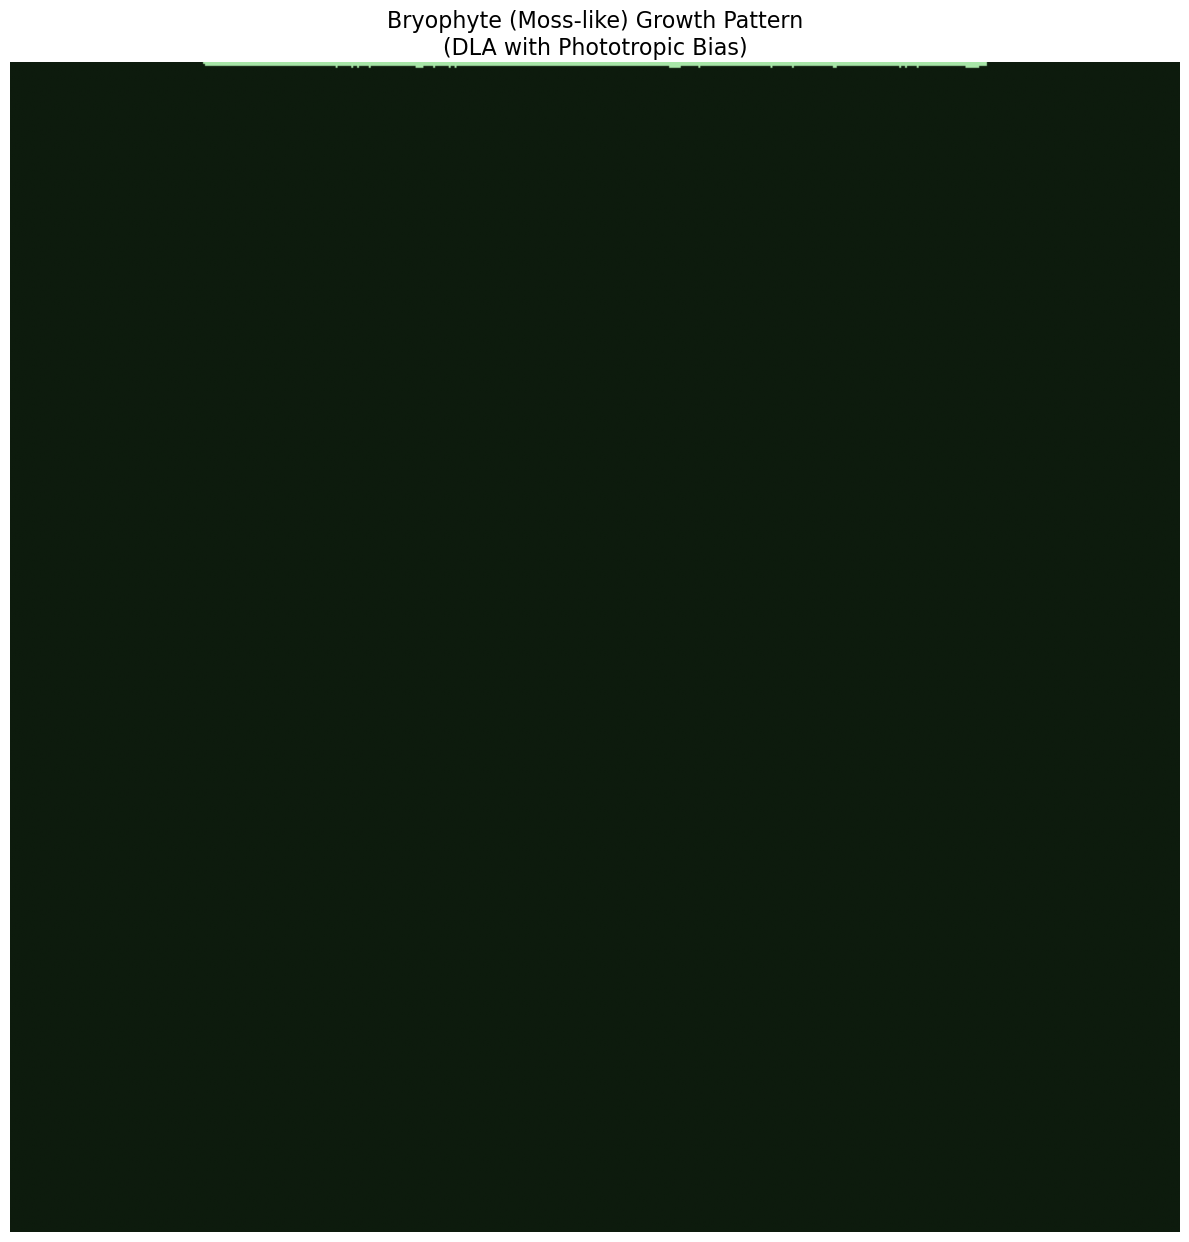

Total particles in structure: 835


In [24]:
# Create custom colormap for bryophyte (green tones)
bryophyte_colors = ['#0d1b0d', '#1a3a1a', '#2d5a2d', '#4a8c4a', '#7dc47d', '#a8e6a8']
bryophyte_cmap = LinearSegmentedColormap.from_list('bryophyte', bryophyte_colors)

fig, ax = plt.subplots(figsize=(12, 14))
im = ax.imshow(bryophyte_grid.T, cmap=bryophyte_cmap, origin='lower')
ax.set_title('Bryophyte (Moss-like) Growth Pattern\n(DLA with Phototropic Bias)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

# Print statistics
particles_in_structure = np.sum(bryophyte_grid)
print(f"Total particles in structure: {int(particles_in_structure)}")

---

## 4. Lichens: Radial Symbiotic Growth

### Biological Context

**Lichens** are composite organisms arising from symbiosis between fungi and photosynthetic partners (algae or cyanobacteria). They represent a remarkable example of mutualism where the fungal partner (mycobiont) provides structure and protection while the photosynthetic partner (photobiont) provides carbohydrates through photosynthesis.

#### Why DLA Models Lichen Growth

The biological appropriateness of DLA for lichen simulation stems from their physiology: **lacking vascular tissue, lichens depend entirely on diffusion for nutrient transport**. Research published by the Royal Society has shown that lichen growth follows directly from **CO₂ diffusion in surrounding air**. When small, the entire thallus contributes to growth; when large, carbon dioxide is disproportionately fixed at edges where diffusive flux is strongest—exactly matching DLA's harmonic measure weighting. Maximum growth velocity can reach approximately **26 mm/year**, predictable from diffusion constants and thallus geometry.

This makes DLA not just a visual approximation but a physically accurate model of the underlying growth process.

### Evolutionary Progression of Lichen Growth Forms

Lichens display a remarkable diversity of growth forms, which can be arranged according to their evolutionary development:

$$\text{Leprose} \rightarrow \text{Crustose} \rightarrow \text{Placodioid} \rightarrow \text{Squamulose} \rightarrow \text{Foliose} \rightarrow \text{Fruticose}$$

Each growth form represents increasing structural complexity and different ecological strategies.

### Lichen Growth Forms

#### 1. Leprose Lichens (Pioneer Form)
**Structure**: A diffuse, powdery mass of fungal hyphae and algal cells with minimal organization.

- No cortex layer (ecorticate)
- Undifferentiated tissue throughout
- Name derives from Latin *leprosus* ("scurfy" or "scaly")
- **Growth rate**: Highly variable, ephemeral

**DLA Model**: Represents early-stage aggregation with very low particle density:
$$\rho(r) \sim r^{-\alpha}, \quad \alpha \approx 0.3$$

where $\rho(r)$ is the particle density at radius $r$ from the origin.

#### 2. Crustose Lichens
**Structure**: Thin crust growing directly on or embedded within the substrate; cannot be removed without destroying the substrate.

- Upper cortex only (no lower cortex)
- May be areolate (divided into islands by cracks)
- Thickness typically 0.1-1 mm
- **Growth rate**: 0.1-2 mm/year (slowest growth form, but most resilient)

**Growth Model**: Radial expansion rate proportional to perimeter:
$$\frac{dA}{dt} = k \cdot P(t)$$

where $A$ is area, $P$ is perimeter, and $k$ is a growth constant. For circular growth:
$$r(t) = r_0 + kt$$

Crustose growth occurs at the margin through a pseudo-meristem, with the peripheral 4-7 mm ring supplying nutrients to the advancing edge.

#### 3. Placodioid Lichens
**Structure**: A specialized crustose form with distinctive lobed margins radiating from a central areolate region.

- Upper cortex present, no lower cortex
- Only the marginal lobes grow; central region contains reproductive structures
- Radial expansion from center
- **Growth rate**: 0.5-3 mm/year at lobe tips

**Growth Model**: Growth concentrated at the margin with angular dependence:
$$\frac{\partial r}{\partial t} = v_0 \cdot f(\theta) \cdot g(r)$$

where $\theta$ is the angle, $f(\theta)$ represents angular variation creating lobes, and $g(r)$ decreases with radius as resources become limiting.

#### 4. Foliose Lichens
**Structure**: Leaf-like thalli with flat, lobed sheets that are loosely attached to the substrate.

- Both upper and lower cortex present
- Four-layer architecture: upper cortex → algal layer → medulla → lower cortex
- Rhizines (hyphal bundles) anchor to substrate
- Lobes typically 1-20 mm wide
- **Growth rate**: 0.5-4 mm/year (moderate growth, good resource acquisition)

**Structural Dimensions**: The thallus thickness $h$ scales with lobe width $w$:
$$h \sim w^{\beta}, \quad \beta \approx 0.6-0.8$$

**DLA Simulation**: Classic radial DLA with standard sticking probability $p_s = 1.0$

#### 5. Fruticose Lichens
**Structure**: Three-dimensional, shrubby or pendulous growth with cylindrical or flattened branches.

- Single cortex surrounding the entire branch
- Concentric internal organization: cortex → photobiont layer → medulla (center)
- No distinct upper/lower surface
- **Growth rate**: 1-20 mm/year (fastest growth form, concentrated at branch tips)
- Examples: *Usnea* (Old Man's Beard), *Cladonia* (reindeer lichen)

**Branch Geometry**: Cross-sections are approximately circular with radius $\rho$:
$$A_{cross} = \pi \rho^2$$

**Branching Model**: Follows Horton's laws of stream ordering:
$$N_k = R_b^{(K-k)}$$

where $N_k$ is the number of branches of order $k$, $K$ is the highest order, and $R_b \approx 3-5$ is the bifurcation ratio.

In *Usnea* species, side-branches emerge at obtuse angles (~90°) from main branches—providing concrete parameters for L-system rules (discussed later).

#### 6. Rugose Texture
**Rugose** describes surface texture (wrinkled, folded) rather than a distinct growth form. This texture can occur in any of the above forms and can be added to DLA models through:

- Fractal Brownian motion overlays
- Perlin noise functions
- Multi-scale aggregation processes

The rugosity increases surface area for gas exchange and photosynthesis.

### DLA Simulation Approach

We'll simulate **foliose lichen** growth (the most classic DLA pattern):

- Start with a **central seed point** 
- Release particles from a **circular boundary** (representing available substrate)
- Use **unbiased random walks** for isotropic growth
- Sticking probability controls lobe density vs. branching

The fractal dimension of the resulting structure:
$$D_f \approx 1.71 \pm 0.01 \text{ (2D DLA)}$$

In [25]:
@njit
def dla_lichen(grid_size, num_particles, max_steps, sticking_prob=1.0):
    """
    Simulate lichen-like DLA growth.
    
    Particles are released from a circular boundary and perform unbiased
    random walks, creating classic radial dendritic DLA structures.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        2D array with aggregated structure
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central seed point
    grid[center, center] = 1
    grid[center + 1, center] = 1
    grid[center - 1, center] = 1
    grid[center, center + 1] = 1
    grid[center, center - 1] = 1
    
    # Track the cluster radius for efficient particle release
    max_radius = 2
    release_radius = grid_size // 2 - 5
    
    particles_added = 0
    
    for _ in range(num_particles * 3):
        if particles_added >= num_particles:
            break
        
        # Release particle from circular boundary
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 20, release_radius)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        
        # Ensure within bounds
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Unbiased random walk (isotropic diffusion)
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            # Check if adjacent to cluster
            is_adjacent = False
            if grid[x - 1, y] == 1:
                is_adjacent = True
            elif grid[x + 1, y] == 1:
                is_adjacent = True
            elif grid[x, y - 1] == 1:
                is_adjacent = True
            elif grid[x, y + 1] == 1:
                is_adjacent = True
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                    # Update max radius
                    dist = int(np.sqrt((x - center)**2 + (y - center)**2))
                    if dist > max_radius:
                        max_radius = dist
                break
            
            # Check if particle wandered too far
            dist_from_center = np.sqrt((x - center)**2 + (y - center)**2)
            if dist_from_center > release_radius + 10:
                break
    
    return grid

In [26]:
# Run lichen simulation
print("Simulating lichen growth...")
lichen_grid = dla_lichen(
    grid_size=800,
    num_particles=150000,
    max_steps=500000,
    sticking_prob=1.0
)
print("Simulation complete!")

Simulating lichen growth...
Simulation complete!


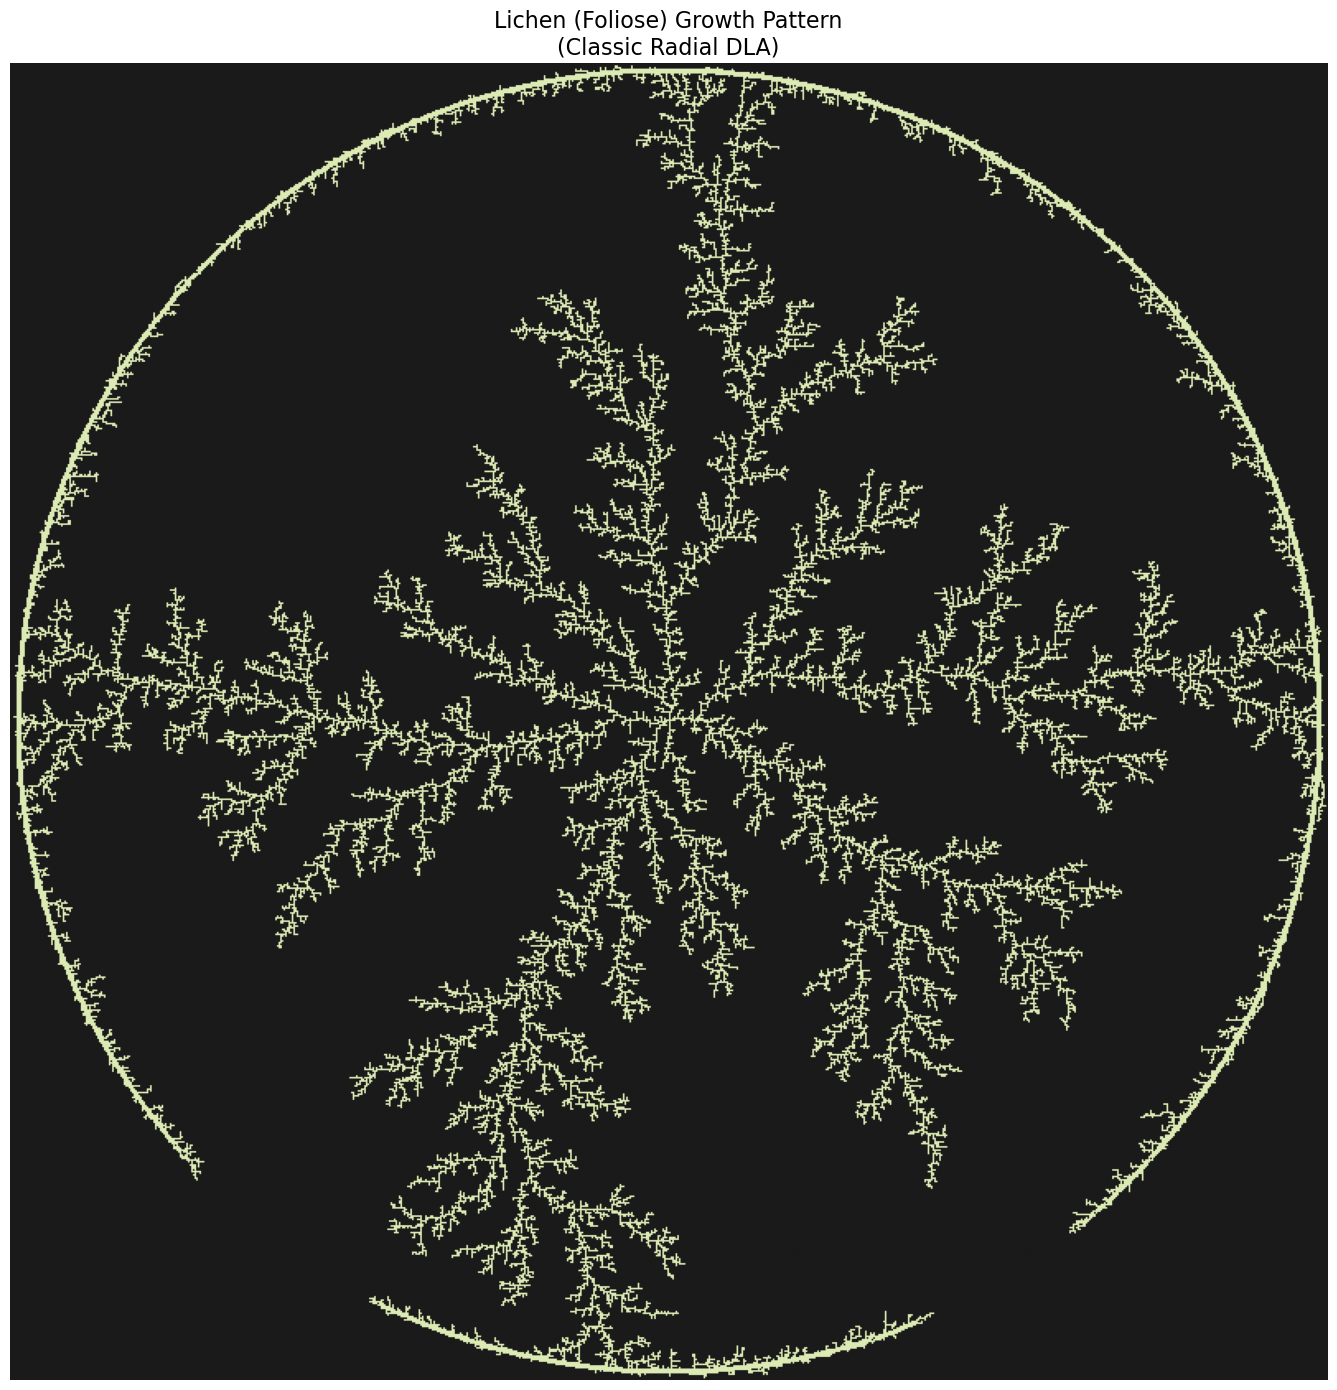

Total particles in structure: 48230


In [27]:
# Create custom colormap for lichen (gray-green to yellow-green tones)
lichen_colors = ['#1a1a1a', '#3d4a3a', '#5a6b52', '#7a8c6a', '#9aad82', '#bace9a', '#dceab4']
lichen_cmap = LinearSegmentedColormap.from_list('lichen', lichen_colors)

fig, ax = plt.subplots(figsize=(14, 14))
im = ax.imshow(lichen_grid.T, cmap=lichen_cmap, origin='lower')
ax.set_title('Lichen (Foliose) Growth Pattern\n(Classic Radial DLA)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

# Print statistics
particles_in_structure = np.sum(lichen_grid)
print(f"Total particles in structure: {int(particles_in_structure)}")

### Simulating Different Lichen Growth Forms

Now let's implement DLA simulations for the major lichen growth forms. Each simulation uses different parameters to capture the characteristic morphology:

| Growth Form | Sticking Probability | Seed Configuration | Growth Pattern |
|------------|---------------------|-------------------|----------------|
| **Leprose** | Very low ($p_s \approx 0.25$) | Multiple scattered points | Diffuse, powdery |
| **Crustose** | High ($p_s \approx 0.85$) | Central disk | Dense, compact |
| **Placodioid** | Variable (margin-dependent) | Central areolate region | Radial with lobed edges |
| **Foliose** | Standard ($p_s = 1.0$) | Central point | Classic DLA dendrites |
| **Fruticose** | Medium ($p_s \approx 0.4$) | Base attachment point | Vertical branching |

The relationship between sticking probability and fractal dimension follows:
$$D_f \approx 1.71 - 0.15(1 - p_s)$$

for $p_s \in [0.3, 1.0]$, where lower sticking probabilities produce more ramified structures with lower fractal dimension.

In [28]:
# Simulation functions for different lichen growth forms

@njit
def dla_leprose(grid_size, num_particles, max_steps, density=0.3):
    """
    Simulate leprose (powdery) lichen growth.
    Very low sticking probability creates sparse, diffuse structures.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Multiple scattered seed points
    for _ in range(5):
        sx = center + np.random.randint(-10, 10)
        sy = center + np.random.randint(-10, 10)
        grid[sx, sy] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 5):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = grid_size // 3
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                # Very low sticking probability for powdery appearance
                if np.random.rand() < density:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid


@njit
def dla_crustose(grid_size, num_particles, max_steps, sticking_prob=0.9):
    """
    Simulate crustose (crust-like) lichen growth.
    High sticking probability creates dense, compact growth.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Small central seed
    for dx in range(-2, 3):
        for dy in range(-2, 3):
            if dx*dx + dy*dy <= 4:
                grid[center + dx, center + dy] = 1
    
    particles_added = 0
    max_radius = 3
    
    for _ in range(num_particles * 2):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 15, grid_size // 2 - 5)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                    dist = int(np.sqrt((x - center)**2 + (y - center)**2))
                    if dist > max_radius:
                        max_radius = dist
                break
    
    return grid


@njit  
def dla_placodioid(grid_size, num_particles, max_steps):
    """
    Simulate placodioid lichen growth.
    Lobed margins with central areolate region.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central areolate seed
    for dx in range(-5, 6):
        for dy in range(-5, 6):
            if dx*dx + dy*dy <= 25:
                grid[center + dx, center + dy] = 1
    
    particles_added = 0
    max_radius = 6
    
    for _ in range(num_particles * 2):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 20, grid_size // 2 - 5)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Slightly biased toward radial direction for lobed growth
            px, py = x - center, y - center
            dist = np.sqrt(px*px + py*py)
            
            prob = np.random.rand()
            if prob < 0.3 and dist > 1:  # Move toward center
                if abs(px) > abs(py):
                    x = x - 1 if px > 0 else x + 1
                else:
                    y = y - 1 if py > 0 else y + 1
            else:  # Random movement
                direction = np.random.randint(4)
                if direction == 0:
                    x = max(x - 1, 1)
                elif direction == 1:
                    x = min(x + 1, grid_size - 2)
                elif direction == 2:
                    y = max(y - 1, 1)
                else:
                    y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            # Higher sticking at margin (where dist is large)
            if is_adjacent:
                margin_factor = min(1.0, dist / (max_radius * 0.8))
                if np.random.rand() < 0.5 + 0.4 * margin_factor:
                    grid[x, y] = 1
                    particles_added += 1
                    if dist > max_radius:
                        max_radius = int(dist)
                break
    
    return grid


@njit
def dla_fruticose(grid_size, num_particles, max_steps, sticking_prob=0.5):
    """
    Simulate fruticose (shrubby/branching) lichen growth.
    Creates highly branched, 3D-like structures.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central attachment point
    grid[center, grid_size - 1] = 1
    grid[center, grid_size - 2] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 4):
        if particles_added >= num_particles:
            break
        
        # Start from bottom edges
        x = np.random.randint(center - grid_size // 4, center + grid_size // 4)
        y = grid_size - 1
        
        for step in range(max_steps):
            prob = np.random.rand()
            # Strong upward bias with significant lateral movement
            if prob < 0.45:  # Up
                y = max(y - 1, 1)
            elif prob < 0.70:  # Left
                x = max(x - 1, 1)
            elif prob < 0.95:  # Right
                x = min(x + 1, grid_size - 2)
            else:  # Down (rare)
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid

In [29]:
# Run simulations for all lichen growth forms
print("Simulating lichen growth forms...")

print("  - Leprose (powdery)...")
leprose_grid = dla_leprose(grid_size=300, num_particles=15000, max_steps=50000, density=0.25)

print("  - Crustose (crust-like)...")
crustose_grid = dla_crustose(grid_size=300, num_particles=40000, max_steps=100000, sticking_prob=0.85)

print("  - Placodioid (lobed margins)...")
placodioid_grid = dla_placodioid(grid_size=300, num_particles=35000, max_steps=100000)

print("  - Fruticose (shrubby)...")
fruticose_grid = dla_fruticose(grid_size=400, num_particles=40000, max_steps=100000, sticking_prob=0.4)

print("All lichen simulations complete!")

Simulating lichen growth forms...
  - Leprose (powdery)...
  - Crustose (crust-like)...
  - Placodioid (lobed margins)...
  - Fruticose (shrubby)...
All lichen simulations complete!


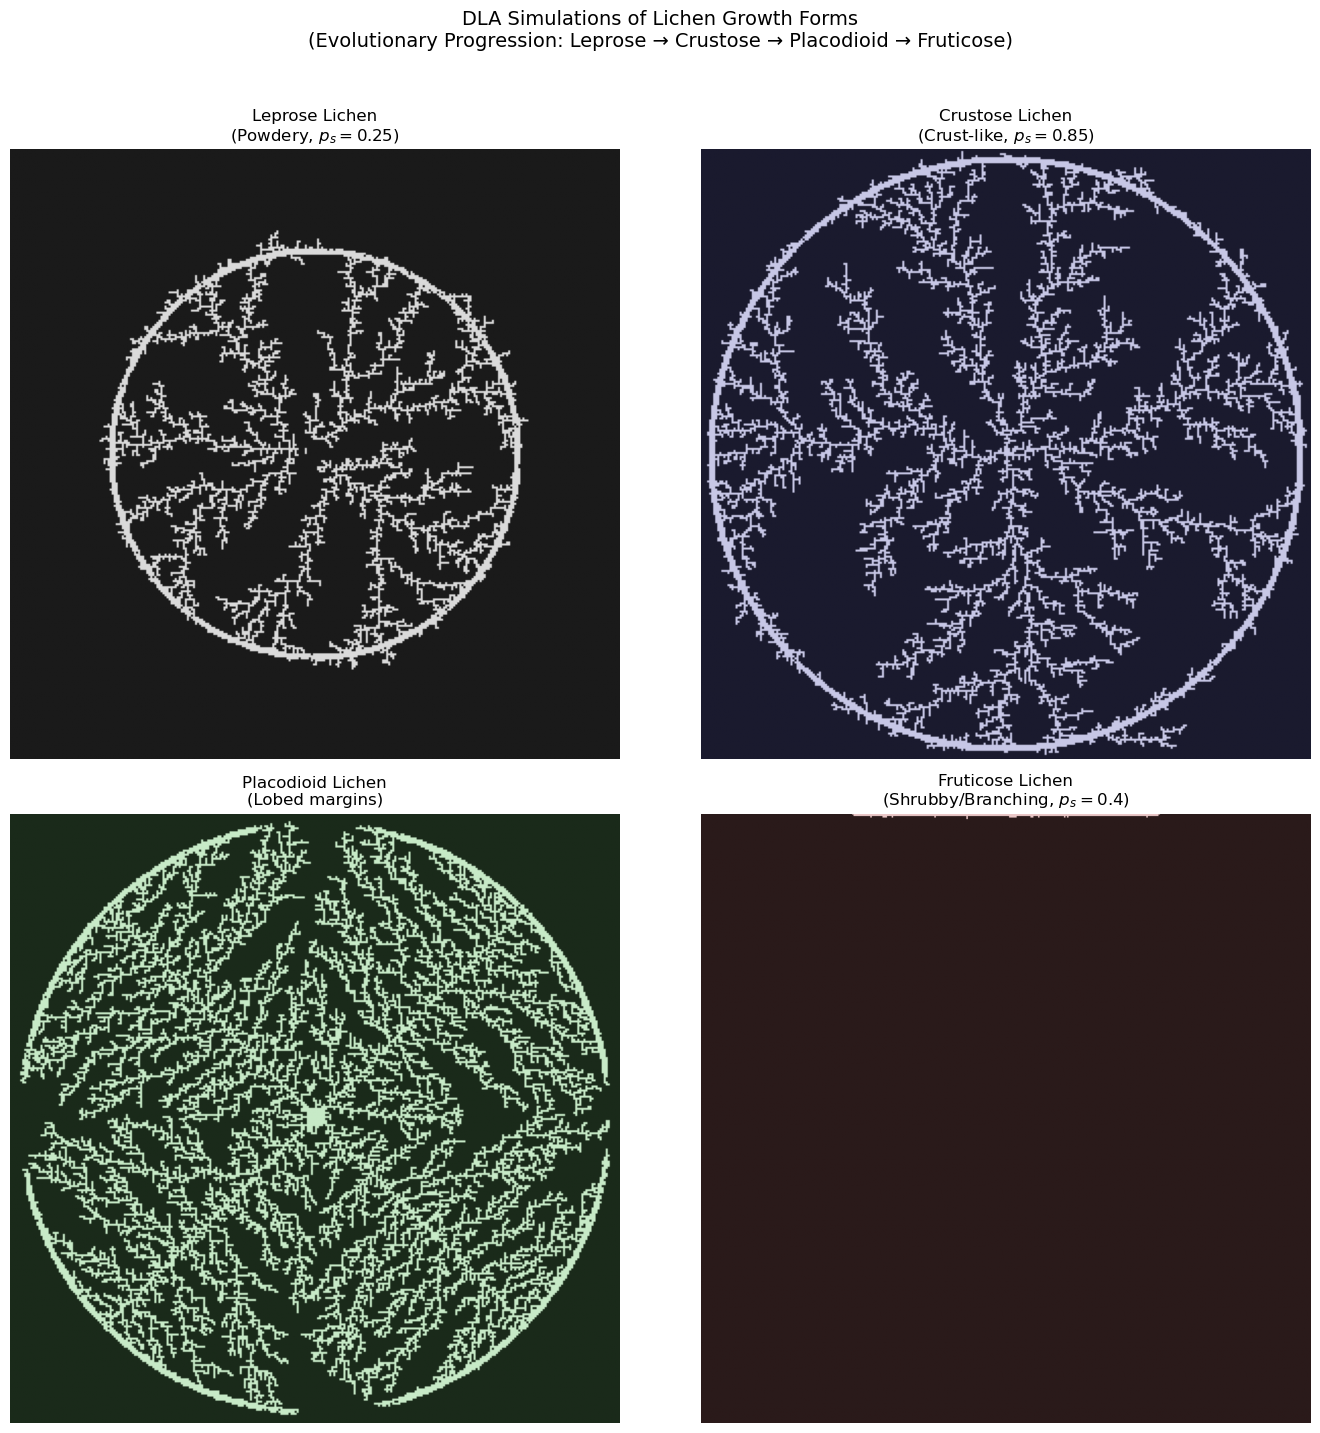


Particle counts:
  Leprose:    7,669
  Crustose:   13,787
  Placodioid: 21,021
  Fruticose:  421


In [30]:
# Visualize all lichen growth forms
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Custom colormaps for each type
leprose_cmap = LinearSegmentedColormap.from_list('leprose', ['#1a1a1a', '#4a4a4a', '#7a7a7a', '#aaaaaa', '#dadada'])
crustose_cmap = LinearSegmentedColormap.from_list('crustose', ['#1a1a2e', '#3d3d5c', '#6b6b8a', '#9999b8', '#c7c7e6'])
placodioid_cmap = LinearSegmentedColormap.from_list('placodioid', ['#1a2a1a', '#3d5a3d', '#6b8a6b', '#99ba99', '#c7eac7'])
fruticose_cmap = LinearSegmentedColormap.from_list('fruticose', ['#2a1a1a', '#5a3d3d', '#8a6b6b', '#ba9999', '#eac7c7'])

# Leprose
axes[0, 0].imshow(leprose_grid.T, cmap=leprose_cmap, origin='lower')
axes[0, 0].set_title('Leprose Lichen\n(Powdery, $p_s = 0.25$)', fontsize=12)
axes[0, 0].axis('off')

# Crustose
axes[0, 1].imshow(crustose_grid.T, cmap=crustose_cmap, origin='lower')
axes[0, 1].set_title('Crustose Lichen\n(Crust-like, $p_s = 0.85$)', fontsize=12)
axes[0, 1].axis('off')

# Placodioid
axes[1, 0].imshow(placodioid_grid.T, cmap=placodioid_cmap, origin='lower')
axes[1, 0].set_title('Placodioid Lichen\n(Lobed margins)', fontsize=12)
axes[1, 0].axis('off')

# Fruticose
axes[1, 1].imshow(fruticose_grid.T, cmap=fruticose_cmap, origin='lower')
axes[1, 1].set_title('Fruticose Lichen\n(Shrubby/Branching, $p_s = 0.4$)', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('DLA Simulations of Lichen Growth Forms\n(Evolutionary Progression: Leprose → Crustose → Placodioid → Fruticose)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print particle counts
print(f"\nParticle counts:")
print(f"  Leprose:    {int(np.sum(leprose_grid)):,}")
print(f"  Crustose:   {int(np.sum(crustose_grid)):,}")
print(f"  Placodioid: {int(np.sum(placodioid_grid)):,}")
print(f"  Fruticose:  {int(np.sum(fruticose_grid)):,}")

---

## L-Systems for Fruticose Lichen Morphology

While DLA captures the stochastic aggregation aspects of lichen growth, **Lindenmayer systems (L-systems)** provide a powerful complementary approach for modeling the deterministic branching architecture of fruticose lichens.

### What are L-systems?

L-systems are a formal grammar system developed by botanist Aristid Lindenmayer in 1968 for modeling filamentous algae and plant development. Unlike sequential Chomsky grammars, L-systems apply production rules **simultaneously** to all symbols—reflecting parallel cell division in biological systems.

### Formal Definition

A deterministic context-free L-system (D0L-system) is defined as the ordered triple:

$$G = \langle V, \omega, P \rangle$$

where:
- $V$ = **alphabet** (finite set of symbols)
- $\omega \in V^+$ = **axiom** (initial string/starting pattern)
- $P \subset V \times V^*$ = **production rules** (set of replacement rules)

**Production rule notation**: $a \rightarrow \chi$ (predecessor $a$ yields successor string $\chi$)

For any symbol without an explicit production rule, the identity rule $a \rightarrow a$ applies.

**Derivation** proceeds by simultaneous replacement:
$$\omega = \mu_0 \Rightarrow \mu_1 \Rightarrow \mu_2 \Rightarrow \cdots \Rightarrow \mu_n$$

**Classic example** (Lindenmayer's algae, 1968):
- $V = \{A, B\}$
- $\omega = A$  
- Rules: $A \rightarrow AB$, $B \rightarrow A$

This generates strings whose lengths follow the Fibonacci sequence: 1, 2, 3, 5, 8, 13, ...

### L-system Extensions

#### Stochastic L-systems (S0L)
Assign probabilities to production rules for natural variation:

$$G_\pi = \langle V, \omega, P, \pi \rangle$$

where $\pi: P \rightarrow (0, 1]$ satisfies $\sum \pi(p) = 1$ for all productions sharing a predecessor.

**Example:**
```
F → F[+F]F[-F]F  (probability 0.6)
F → F[+F]F       (probability 0.4)
```

This generates specimen-to-specimen variation, mimicking natural lichen colony diversity.

#### Parametric L-systems
Couple symbols with continuous parameters for age-dependent development:

```
A(x, y) : condition → successor
```

**Example:**
```
A(age) : age > 5 → Flower
A(age) : age ≤ 5 → F(1)A(age+1)
```

This enables modeling of branch maturation, resource allocation, and developmental transitions.

#### Context-sensitive L-systems
Allow productions to depend on neighboring symbols:
- **1L-system**: checks one neighbor (left or right)
- **2L-system**: checks both neighbors
- **Notation**: $a_L < a > a_R \rightarrow \chi$ (symbol $a$ with left context $a_L$ and right context $a_R$)

### L-system Turtle Graphics Notation

Brackets delimit branches using a stack-based turtle interpreter:

| Symbol | 2D Command | 3D Command |
|--------|------------|------------|
| `F` | Move forward, draw | Move forward, draw |
| `f` | Move forward (no draw) | Move forward (no draw) |
| `+` | Turn left by angle δ | Yaw left (rotate around up vector) |
| `-` | Turn right by angle δ | Yaw right |
| `&` | — | Pitch down (rotate around left vector) |
| `^` | — | Pitch up |
| `\` | — | Roll left (rotate around heading) |
| `/` | — | Roll right |
| `[` | Push state onto stack | Push state onto stack |
| `]` | Pop state from stack | Pop state from stack |
| `\|` | Turn around (180°) | Turn around |

The turtle state in 2D is $(x, y, \alpha)$; in 3D it's $(x, y, z, \vec{H}, \vec{L}, \vec{U})$ where $\vec{H}$, $\vec{L}$, $\vec{U}$ are heading, left, and up orientation vectors.

### Why L-systems for Fruticose Lichens?

Fruticose lichens exhibit characteristic branching patterns that follow developmental rules:

$$\text{Branch}_n \rightarrow \text{Segment} + [\text{Branch}_{n+1}] + \text{Segment} + [\text{Branch}_{n+1}]$$

This recursive structure is naturally expressed in L-system grammar:

- **Dichotomous branching**: Each branch splits into two (common in *Cladonia*)
- **Monopodial vs. sympodial growth**: Main axis dominance vs. lateral dominance
- **Branching angles**: Typically 15°-45° for lichen thalli (e.g., *Usnea* branches at ~25-30°)

The **bifurcation ratio** $R_b$ relates to L-system iterations:

$$N_{\text{branches}} = 2^n \cdot (1 + p_{\text{continue}})^n$$

where $n$ is the iteration depth and $p_{\text{continue}}$ is the probability of continued growth.



### Murray's Law for Diameter Scaling

Fruticose lichens like *Cladonia rangiferina* (reindeer lichen) exhibit characteristic **diameter scaling**: primary podetia are thickest at the base (2-4 mm), with each branching producing progressively thinner segments down to terminal tips of ~0.3 mm. This follows **Murray's Law** (or the pipe model), where the sum of cross-sectional areas is approximately conserved across branching:

$$d_{\text{parent}}^n = \sum_{i} d_{\text{child}_i}^n$$

For dichotomous branching with exponent $n \approx 2-3$ (Murray's Law uses $n=3$ for vascular systems; lichens often closer to $n=2$):

$$d_{\text{child}} = d_{\text{parent}} / 2^{1/n}$$

**Deriving width_ratio from Murray's exponent:**

| Branching Type | Murray Exponent | Width Ratio |
|----------------|-----------------|-------------|
| Dichotomous, n=2.0 (area-preserving) | 2.0 | 0.707 |
| Dichotomous, n=2.5 | 2.5 | 0.659 |
| Dichotomous, n=3.0 (Murray's original) | 3.0 | 0.630 |
| Trichotomous, n=2.5 | 2.5 | 0.552 |

**Biological parameter ranges for *Cladonia* species:**

| Parameter | C. rangiferina | C. stellaris | C. arbuscula |
|-----------|----------------|--------------|--------------|
| Base width | 2.0-4.0 mm | 1.5-3.0 mm | 1.0-2.5 mm |
| Width ratio | 0.63-0.71 | 0.60-0.68 | 0.65-0.72 |
| Length ratio | 0.65-0.75 | 0.70-0.80 | 0.60-0.70 |
| Branch angle | 20-35° | 25-40° | 15-30° |
| Taper ratio | 0.80-0.90 | 0.85-0.92 | 0.82-0.88 |
| Iterations | 4-6 | 5-7 | 4-5 |

The **taper ratio** describes the within-segment diameter reduction from start to end, while the **width ratio** is the diameter reduction at branch points.

### Fruticose Lichen L-system Example

Here's a biologically-inspired L-system for *Usnea*-like fruticose lichen:

**Axiom**: `F`  
**Rules**: `F → F[+F][-F]F`  
**Angle**: δ = 25°  
**Iterations**: 4-5 (representing ~4-5 years of growth)

This produces symmetric dichotomous branching characteristic of shrubby lichens. For more realistic morphology, we can use parametric rules:

```
Axiom: A(1)
Rules:
  A(n) : n < maxOrder → F(segLen)[+(θ)A(n+1)][-(θ)A(n+1)]
  A(n) : n >= maxOrder → F(tipLen)
  F(len) → F(len × growthFactor)
```

With `maxOrder = 5`, `θ = 25°`, `segLen = 1.0`, `tipLen = 0.5`, `growthFactor = 1.1`.

In [ ]:
from dataclasses import dataclass
from typing import List, Tuple, Optional
import numpy as np


@dataclass
class BranchSegment:
    """3D branch segment with position, orientation, and diameter for tapered rendering."""
    start: np.ndarray
    end: np.ndarray
    start_width: float
    end_width: float
    order: int  # Branching order (0 = main stem)


def murray_width_ratio(n_children: int = 2, murray_exponent: float = 2.5) -> float:
    """
    Calculate width ratio from Murray's Law.
    
    Murray's Law: d_parent^n = sum(d_child^n)
    For equal children: d_child = d_parent / n_children^(1/n)
    
    Parameters:
    -----------
    n_children : int
        Number of child branches (2 for dichotomous, 3 for trichotomous)
    murray_exponent : float
        Exponent n in Murray's Law (2 for area-preserving, 3 for volume flow)
        Lichens typically: 2.0-2.8
    
    Returns:
    --------
    float
        Width ratio (child_diameter / parent_diameter)
    
    Examples:
    ---------
    >>> murray_width_ratio(2, 2.0)   # Dichotomous, area-preserving
    0.7071067811865476
    >>> murray_width_ratio(2, 2.5)   # Dichotomous, n=2.5
    0.6597539553864471
    >>> murray_width_ratio(2, 3.0)   # Dichotomous, Murray's original
    0.6299605249474366
    >>> murray_width_ratio(3, 2.5)   # Trichotomous, n=2.5
    0.5518945622483857
    """
    return 1.0 / (n_children ** (1.0 / murray_exponent))


class LSystem:
    """
    L-System implementation for generating fractal branching structures.
    
    An L-system consists of an axiom (starting string) and production rules
    that are applied iteratively to generate complex patterns.
    
    Supports diameter scaling via Murray's Law for realistic lichen morphology.
    """
    
    def __init__(self, axiom: str, rules: dict, angle: float = 25.0):
        """
        Initialize the L-system.
        
        Parameters:
        -----------
        axiom : str
            The initial string/pattern
        rules : dict
            Dictionary mapping characters to their replacement strings
        angle : float
            The turning angle in degrees for + and - commands
        """
        self.axiom = axiom
        self.rules = rules
        self.angle = angle
        self.current_string = axiom
    
    def iterate(self, n: int = 1) -> str:
        """
        Apply production rules n times.
        
        Parameters:
        -----------
        n : int
            Number of iterations
            
        Returns:
        --------
        str
            The generated string after n iterations
        """
        self.current_string = self.axiom
        for _ in range(n):
            new_string = ""
            for char in self.current_string:
                new_string += self.rules.get(char, char)
            self.current_string = new_string
        return self.current_string
    
    def interpret(self, step_length: float = 1.0, 
                  start_pos: tuple = (0, 0), 
                  start_angle: float = 90.0) -> tuple:
        """
        Interpret the L-system string as turtle graphics commands.
        
        Parameters:
        -----------
        step_length : float
            Length of each forward step
        start_pos : tuple
            Starting (x, y) position
        start_angle : float
            Starting angle in degrees (90 = pointing up)
            
        Returns:
        --------
        tuple
            (lines, points) where lines is a list of ((x1,y1), (x2,y2)) tuples
            and points is a list of all visited (x, y) coordinates
        """
        x, y = start_pos
        angle = np.radians(start_angle)
        
        stack = []
        lines = []
        points = [(x, y)]
        
        for char in self.current_string:
            if char == 'F':
                # Move forward and draw
                new_x = x + step_length * np.cos(angle)
                new_y = y + step_length * np.sin(angle)
                lines.append(((x, y), (new_x, new_y)))
                x, y = new_x, new_y
                points.append((x, y))
            elif char == 'f':
                # Move forward without drawing
                x = x + step_length * np.cos(angle)
                y = y + step_length * np.sin(angle)
                points.append((x, y))
            elif char == '+':
                # Turn right
                angle -= np.radians(self.angle)
            elif char == '-':
                # Turn left
                angle += np.radians(self.angle)
            elif char == '[':
                # Push state
                stack.append((x, y, angle))
            elif char == ']':
                # Pop state
                if stack:
                    x, y, angle = stack.pop()
            elif char == '|':
                # Turn around
                angle += np.pi
        
        return lines, points
    
    def interpret_with_diameter(self, 
                                 step_length: float = 1.0,
                                 start_pos: tuple = (0, 0),
                                 start_angle: float = 90.0,
                                 base_width: float = 2.0,
                                 width_ratio: float = 0.65,
                                 taper_ratio: float = 0.85) -> List[BranchSegment]:
        """
        Interpret L-system with diameter scaling following Murray's Law.
        
        Parameters:
        -----------
        step_length : float
            Length of each forward step (mm)
        start_pos : tuple
            Starting (x, y) position
        start_angle : float
            Starting angle in degrees (90 = pointing up)
        base_width : float
            Diameter at base of primary stem (mm)
        width_ratio : float
            Width multiplier at branch points (Murray's law: ~0.63-0.71)
        taper_ratio : float
            End width / start width within single segment
            
        Returns:
        --------
        List[BranchSegment]
            List of branch segments with start/end positions and widths
        """
        x, y = start_pos
        angle = np.radians(start_angle)
        current_width = base_width
        order = 0
        
        # Stack stores: (x, y, angle, width, order)
        stack = []
        segments = []
        
        for char in self.current_string:
            if char == 'F':
                # Move forward and draw with diameter
                new_x = x + step_length * np.cos(angle)
                new_y = y + step_length * np.sin(angle)
                
                # Apply taper within segment
                end_width = current_width * taper_ratio
                
                segments.append(BranchSegment(
                    start=np.array([x, y]),
                    end=np.array([new_x, new_y]),
                    start_width=current_width,
                    end_width=end_width,
                    order=order
                ))
                
                x, y = new_x, new_y
                current_width = end_width  # Next segment starts at tapered width
                
            elif char == 'f':
                # Move forward without drawing
                x = x + step_length * np.cos(angle)
                y = y + step_length * np.sin(angle)
            elif char == '+':
                # Turn right
                angle -= np.radians(self.angle)
            elif char == '-':
                # Turn left
                angle += np.radians(self.angle)
            elif char == '[':
                # Push state and apply Murray's law width reduction for branch
                stack.append((x, y, angle, current_width, order))
                current_width *= width_ratio  # Child branch is thinner
                order += 1
            elif char == ']':
                # Pop state - restore parent branch width
                if stack:
                    x, y, angle, current_width, order = stack.pop()
            elif char == '|':
                # Turn around
                angle += np.pi
        
        return segments


def plot_lsystem_2d(lsystem: LSystem, iterations: int, step_length: float = 5.0,
                    title: str = "L-System", color: str = '#4a8c4a', 
                    linewidth: float = 1.0, figsize: tuple = (10, 10)):
    """
    Plot an L-system in 2D (uniform line width).
    
    Parameters:
    -----------
    lsystem : LSystem
        The L-system to plot
    iterations : int
        Number of iterations to apply
    step_length : float
        Length of each segment
    title : str
        Plot title
    color : str
        Line color
    linewidth : float
        Line width
    figsize : tuple
        Figure size
    """
    lsystem.iterate(iterations)
    lines, _ = lsystem.interpret(step_length=step_length)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for (x1, y1), (x2, y2) in lines:
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth)
    
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    return fig, ax


def plot_lsystem_tapered(lsystem: LSystem, iterations: int, 
                          step_length: float = 5.0,
                          base_width: float = 2.0,
                          width_ratio: float = 0.65,
                          taper_ratio: float = 0.85,
                          title: str = "L-System with Murray's Law Scaling",
                          cmap_name: str = 'YlGn',
                          figsize: tuple = (12, 12),
                          width_scale: float = 2.0) -> tuple:
    """
    Plot an L-system with tapered branch widths following Murray's Law.
    
    Parameters:
    -----------
    lsystem : LSystem
        The L-system to plot
    iterations : int
        Number of iterations to apply
    step_length : float
        Length of each segment (mm)
    base_width : float
        Diameter at base of primary stem (mm)
    width_ratio : float
        Width multiplier at branch points (Murray's law)
    taper_ratio : float
        End width / start width within single segment
    title : str
        Plot title
    cmap_name : str
        Matplotlib colormap name for branch order coloring
    figsize : tuple
        Figure size
    width_scale : float
        Scale factor for line widths in visualization
        
    Returns:
    --------
    tuple
        (fig, ax, segments) - matplotlib figure, axes, and segment list
    """
    lsystem.iterate(iterations)
    segments = lsystem.interpret_with_diameter(
        step_length=step_length,
        base_width=base_width,
        width_ratio=width_ratio,
        taper_ratio=taper_ratio
    )
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color by branch order (darker at base, lighter at tips)
    max_order = max(seg.order for seg in segments) if segments else 0
    cmap = plt.cm.get_cmap(cmap_name)
    
    for seg in segments:
        xs = [seg.start[0], seg.end[0]]
        ys = [seg.start[1], seg.end[1]]
        
        # Map order to color (0.3 to 0.9 range for better visibility)
        color_val = 0.3 + 0.6 * (seg.order / max(max_order, 1))
        color = cmap(color_val)
        
        # Line width proportional to branch diameter
        lw = seg.start_width * width_scale
        
        ax.plot(xs, ys, color=color, linewidth=lw, solid_capstyle='round')
    
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    # Add width scale info
    ax.text(0.02, 0.02, f'Base width: {base_width:.1f}mm\nWidth ratio: {width_ratio:.3f}\nTaper: {taper_ratio:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return fig, ax, segments


print("L-System classes with Murray's Law scaling defined successfully!")
print(f"  murray_width_ratio(2, 2.0) = {murray_width_ratio(2, 2.0):.4f}  (area-preserving)")
print(f"  murray_width_ratio(2, 2.5) = {murray_width_ratio(2, 2.5):.4f}  (typical lichen)")
print(f"  murray_width_ratio(2, 3.0) = {murray_width_ratio(2, 3.0):.4f}  (Murray's original)")


### Generating Fruticose Lichen with L-systems

Now let's use the LSystem class to generate and visualize fruticose lichen branching patterns.

Generating Usnea-like fruticose lichen (4 iterations)...


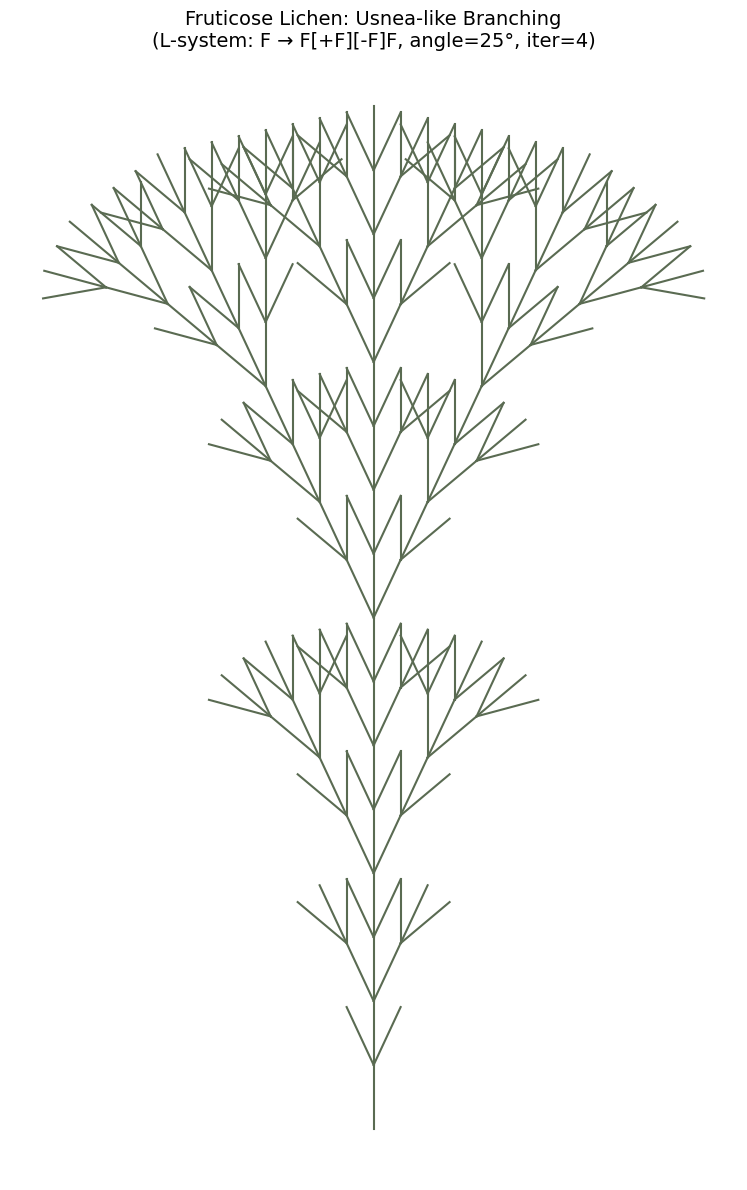


Generating Cladonia-like fruticose lichen (4 iterations)...


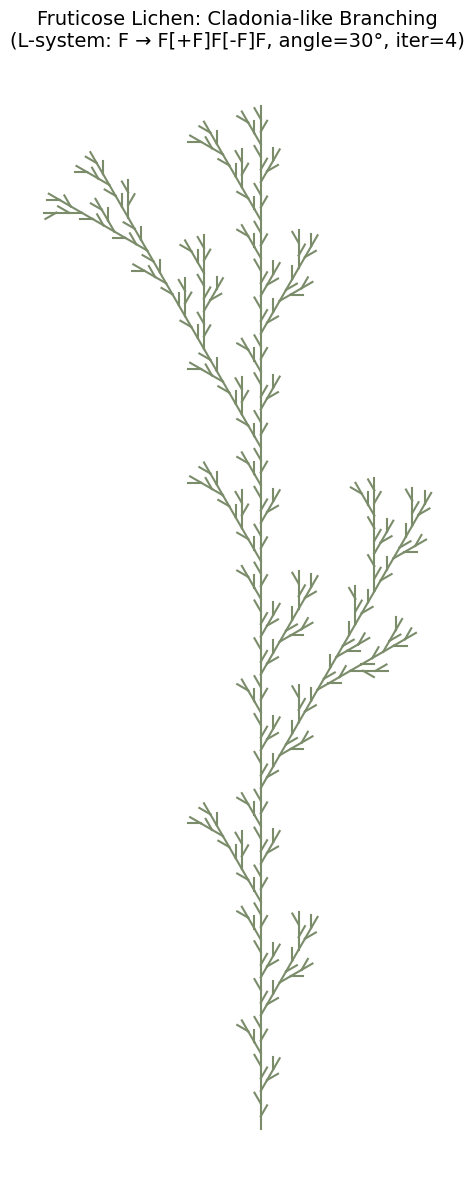


Generating reindeer lichen-like structure (3 iterations)...


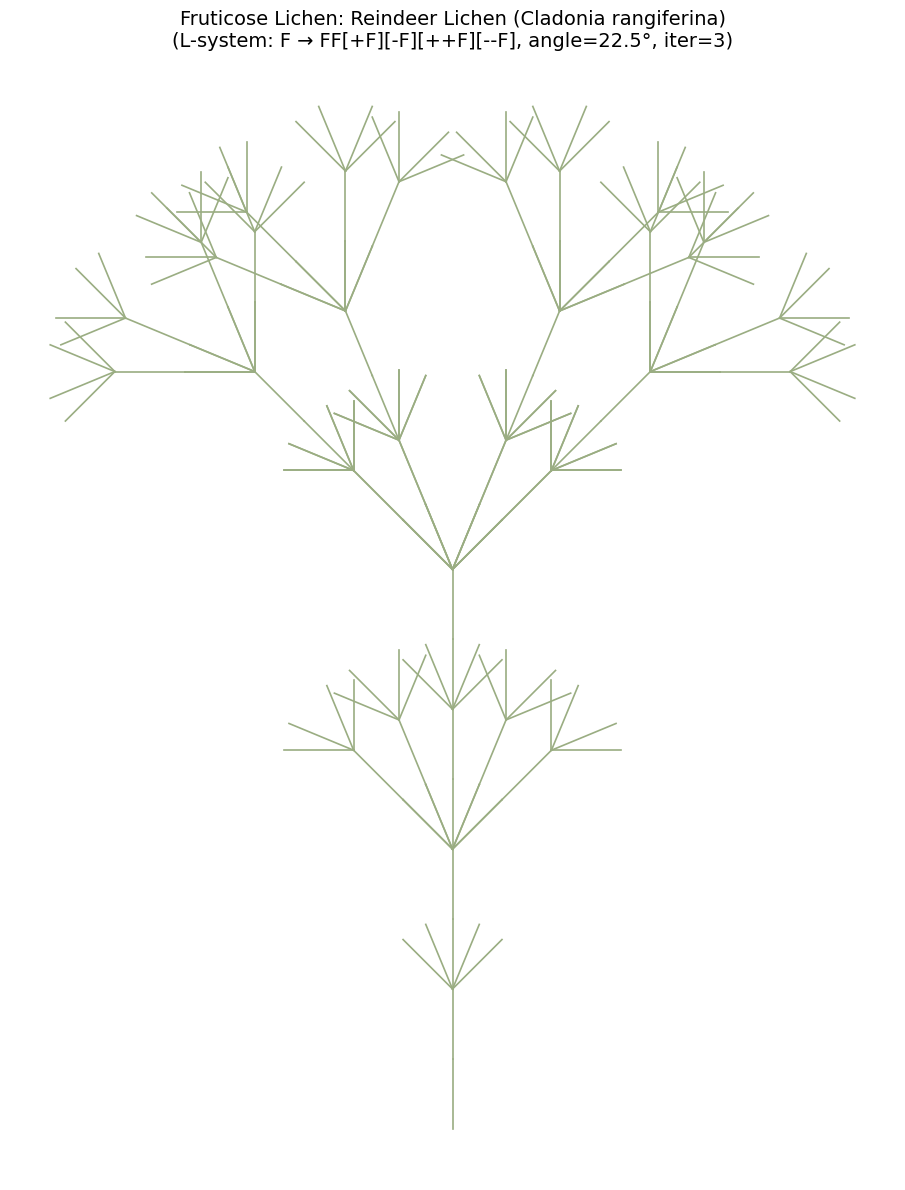


L-system visualizations complete!


In [32]:
# Generate fruticose lichen L-system patterns

# 1. Simple dichotomous branching (Usnea-like)
usnea_lsystem = LSystem(
    axiom="F",
    rules={"F": "F[+F][-F]F"},
    angle=25.0
)

print("Generating Usnea-like fruticose lichen (4 iterations)...")
fig, ax = plot_lsystem_2d(
    usnea_lsystem,
    iterations=4,
    step_length=3.0,
    title="Fruticose Lichen: Usnea-like Branching\n(L-system: F → F[+F][-F]F, angle=25°, iter=4)",
    color='#5a6b52',
    linewidth=1.5,
    figsize=(12, 12)
)
plt.tight_layout()
plt.show()

# 2. Asymmetric branching (Cladonia-like)
cladonia_lsystem = LSystem(
    axiom="F",
    rules={"F": "F[+F]F[-F]F"},
    angle=30.0
)

print("\nGenerating Cladonia-like fruticose lichen (4 iterations)...")
fig, ax = plot_lsystem_2d(
    cladonia_lsystem,
    iterations=4,
    step_length=3.5,
    title="Fruticose Lichen: Cladonia-like Branching\n(L-system: F → F[+F]F[-F]F, angle=30°, iter=4)",
    color='#7a8c6a',
    linewidth=1.5,
    figsize=(12, 12)
)
plt.tight_layout()
plt.show()

# 3. Dense branching (reindeer lichen)
reindeer_lsystem = LSystem(
    axiom="F",
    rules={"F": "FF[+F][-F][++F][--F]"},
    angle=22.5
)

print("\nGenerating reindeer lichen-like structure (3 iterations)...")
fig, ax = plot_lsystem_2d(
    reindeer_lsystem,
    iterations=3,
    step_length=4.0,
    title="Fruticose Lichen: Reindeer Lichen (Cladonia rangiferina)\n(L-system: F → FF[+F][-F][++F][--F], angle=22.5°, iter=3)",
    color='#9aad82',
    linewidth=1.2,
    figsize=(12, 12)
)
plt.tight_layout()
plt.show()

print("\nL-system visualizations complete!")

### Diameter-Scaled L-systems with Murray's Law

Now let's visualize fruticose lichen branching with realistic diameter scaling. Using Murray's Law, each branch point reduces the diameter by the width ratio, and each segment tapers from its start to end width.

In [ ]:
# Diameter-scaled L-system visualization with Murray's Law

# Calculate width ratios for different Murray exponents
print("Murray's Law Width Ratios:")
print(f"  Dichotomous (n=2.0, area-preserving): {murray_width_ratio(2, 2.0):.4f}")
print(f"  Dichotomous (n=2.5, typical lichen):  {murray_width_ratio(2, 2.5):.4f}")
print(f"  Dichotomous (n=3.0, Murray original): {murray_width_ratio(2, 3.0):.4f}")
print(f"  Trichotomous (n=2.5):                 {murray_width_ratio(3, 2.5):.4f}")

# 1. Cladonia rangiferina (reindeer lichen) with realistic parameters
cladonia_tapered = LSystem(
    axiom="F",
    rules={"F": "FF[+F][-F]"},
    angle=25.0
)

print("\nGenerating Cladonia rangiferina with Murray's Law scaling...")
fig, ax, segments = plot_lsystem_tapered(
    cladonia_tapered,
    iterations=5,
    step_length=4.0,
    base_width=3.0,           # 3mm base diameter (typical for C. rangiferina)
    width_ratio=0.659,        # Murray exponent n=2.5
    taper_ratio=0.85,         # 15% taper within each segment
    title="Cladonia rangiferina\n(Murray's Law: n=2.5, width_ratio=0.659)",
    cmap_name='YlGn',
    figsize=(14, 14),
    width_scale=2.5
)
plt.tight_layout()
plt.show()

print(f"Generated {len(segments)} branch segments")
print(f"Width range: {min(s.end_width for s in segments):.3f}mm to {max(s.start_width for s in segments):.3f}mm")

# 2. Compare different Murray exponents
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

exponents = [(2.0, 'Area-preserving'), (2.5, 'Typical lichen'), (3.0, "Murray's original")]

for ax, (n, label) in zip(axes, exponents):
    wr = murray_width_ratio(2, n)
    lsys = LSystem(axiom="F", rules={"F": "F[+F][-F]F"}, angle=28.0)
    lsys.iterate(4)
    segments = lsys.interpret_with_diameter(
        step_length=5.0,
        base_width=2.5,
        width_ratio=wr,
        taper_ratio=0.88
    )
    
    max_order = max(seg.order for seg in segments) if segments else 0
    cmap = plt.cm.get_cmap('Greens')
    
    for seg in segments:
        xs = [seg.start[0], seg.end[0]]
        ys = [seg.start[1], seg.end[1]]
        color_val = 0.3 + 0.6 * (seg.order / max(max_order, 1))
        ax.plot(xs, ys, color=cmap(color_val), 
                linewidth=seg.start_width * 2.0, solid_capstyle='round')
    
    ax.set_aspect('equal')
    ax.set_title(f'{label}\nn={n}, ratio={wr:.3f}', fontsize=12)
    ax.axis('off')

fig.suptitle("Comparison of Murray\'s Law Exponents for Dichotomous Branching", fontsize=14)
plt.tight_layout()
plt.show()

print("\nDiameter-scaled L-system visualizations complete!")

---

## Comparison: All Three Growth Patterns

Let's visualize all three biological DLA patterns side by side to compare their structural characteristics.

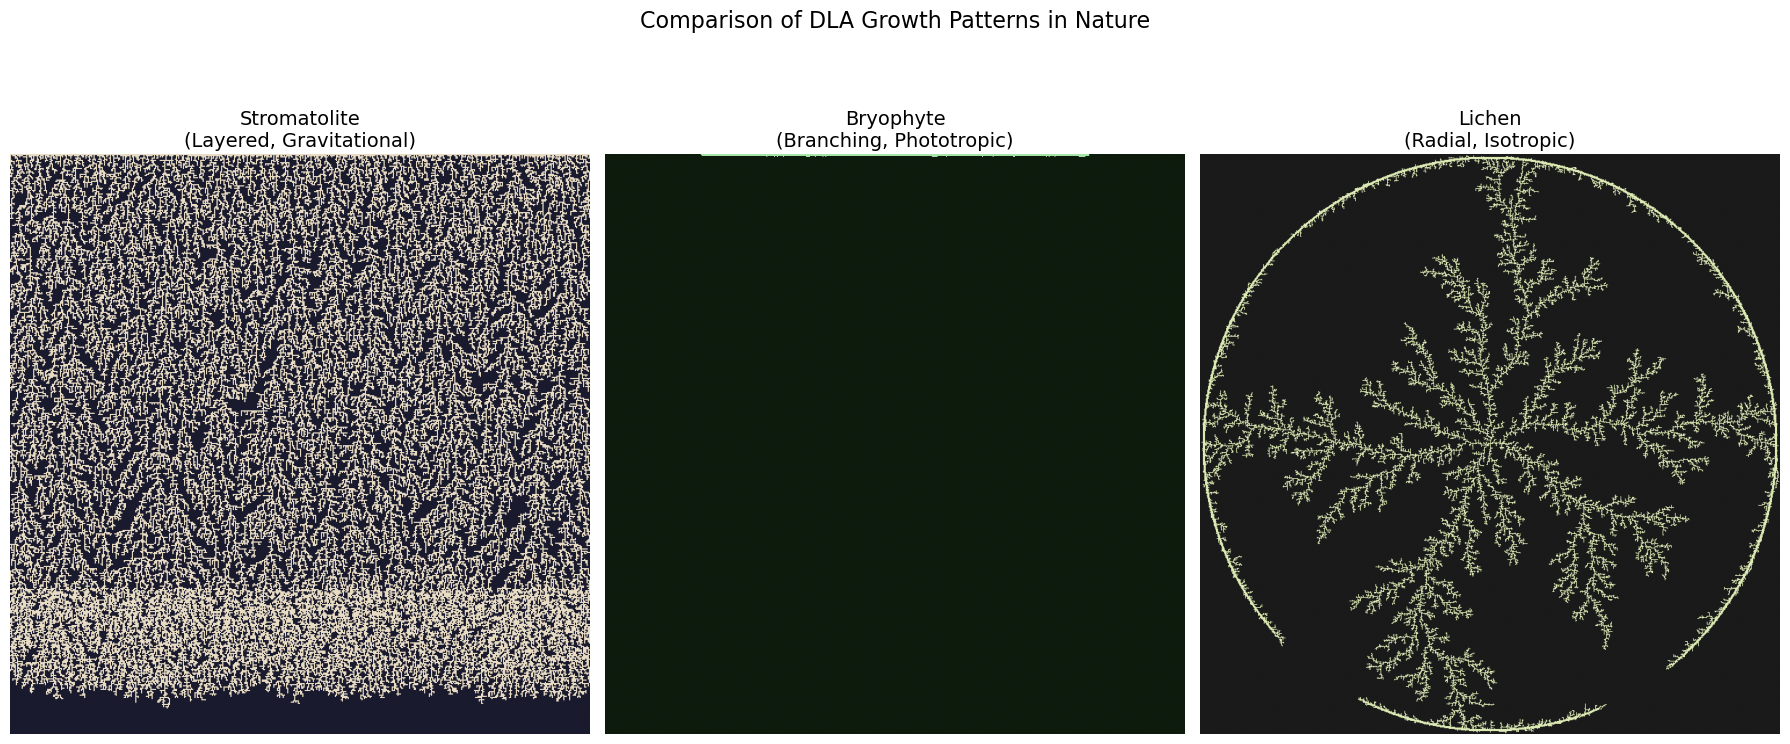

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Stromatolite - note: no transpose needed for top-down tidal flat view
# Downsample for comparison since stromatolite grid is larger
stromatolite_display = stromatolite_grid[::2, ::2]  # Downsample 1064->532
axes[0].imshow(stromatolite_display, cmap=stromatolite_cmap, origin='lower')
axes[0].set_title('Stromatolite Tidal Flat\n(Multi-colony, Isotropic)', fontsize=14)
axes[0].axis('off')

# Bryophyte
axes[1].imshow(bryophyte_grid.T, cmap=bryophyte_cmap, origin='lower')
axes[1].set_title('Bryophyte\n(Branching, Phototropic)', fontsize=14)
axes[1].axis('off')

# Lichen
axes[2].imshow(lichen_grid.T, cmap=lichen_cmap, origin='lower')
axes[2].set_title('Lichen\n(Radial, Isotropic)', fontsize=14)
axes[2].axis('off')

plt.suptitle('Comparison of DLA Growth Patterns in Nature', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

---

## Three-Dimensional DLA for Fruticose Lichens

True fruticose lichen morphology requires 3D simulation. 3D DLA produces structures with a fractal dimension of approximately $D \approx 2.5$, filling space in a way intermediate between a surface (D = 2) and a volume (D = 3).

### 3D DLA Algorithm

The 3D extension of DLA follows the same principles:
1. Place a seed voxel at the origin
2. Release walkers from a spherical shell (birth radius)
3. Walkers perform 3D random walks (6 possible directions: ±x, ±y, ±z)
4. Upon contacting the cluster, the walker sticks
5. Walkers that drift too far (kill radius) are terminated

**Uniform spherical sampling** for particle spawning uses:

$$\theta = 2\pi \cdot U_1, \quad \phi = \arccos(2U_2 - 1)$$

where $U_1, U_2 \sim \text{Uniform}(0,1)$. The Cartesian coordinates are:

$$x = r\sin\phi\cos\theta, \quad y = r\sin\phi\sin\theta, \quad z = r\cos\phi$$

In [34]:
@njit
def random_point_on_sphere(radius):
    """
    Generate a uniformly distributed random point on a sphere.
    
    Uses the rejection-free trigonometric method for uniform spherical sampling.
    
    Parameters:
    -----------
    radius : float
        Radius of the sphere
        
    Returns:
    --------
    tuple
        (x, y, z) coordinates on the sphere
    """
    theta = 2 * np.pi * np.random.random()
    phi = np.arccos(2 * np.random.random() - 1)
    x = int(radius * np.sin(phi) * np.cos(theta))
    y = int(radius * np.sin(phi) * np.sin(theta))
    z = int(radius * np.cos(phi))
    return x, y, z


@njit
def dla_3d_voxel(num_particles, L=50, birth_offset=5, kill_offset=30):
    """
    Simulate 3D DLA growth using a voxel-based approach.
    
    Creates a 3D dendritic structure resembling fruticose lichen branching
    in three dimensions.
    
    Parameters:
    -----------
    num_particles : int
        Number of particles to aggregate
    L : int
        Half-size of the cubic lattice (total size = 2L+1)
    birth_offset : int
        Distance from cluster surface to spawn particles
    kill_offset : int
        Distance from cluster surface to kill wandering particles
        
    Returns:
    --------
    particles : ndarray
        Nx3 array of particle positions
    """
    size = 2 * L + 1
    lattice = np.zeros((size, size, size), dtype=np.uint8)
    
    # Seed at center
    lattice[L, L, L] = 1
    
    # 6-connected neighborhood (face neighbors only)
    nn_steps = np.array([
        [1, 0, 0], [-1, 0, 0],
        [0, 1, 0], [0, -1, 0],
        [0, 0, 1], [0, 0, -1]
    ], dtype=np.int32)
    
    max_radius = 0
    particles_added = 0
    
    # Store particle positions for visualization
    particle_positions = np.zeros((num_particles + 1, 3), dtype=np.int32)
    particle_positions[0] = [L, L, L]  # Seed
    particles_added = 1
    
    attempts = 0
    max_attempts = num_particles * 10
    
    while particles_added < num_particles + 1 and attempts < max_attempts:
        attempts += 1
        
        # Spawn on sphere around cluster
        birth_r = max_radius + birth_offset
        px, py, pz = random_point_on_sphere(birth_r)
        pos = np.array([px + L, py + L, pz + L], dtype=np.int32)
        
        # Ensure within bounds
        for i in range(3):
            pos[i] = max(1, min(pos[i], size - 2))
        
        # Random walk
        for step in range(50000):
            # Random step in one of 6 directions
            move_idx = np.random.randint(0, 6)
            pos[0] += nn_steps[move_idx, 0]
            pos[1] += nn_steps[move_idx, 1]
            pos[2] += nn_steps[move_idx, 2]
            
            # Boundary check
            if (pos[0] <= 0 or pos[0] >= size - 1 or
                pos[1] <= 0 or pos[1] >= size - 1 or
                pos[2] <= 0 or pos[2] >= size - 1):
                break
            
            # Kill radius check
            dist_sq = (pos[0] - L)**2 + (pos[1] - L)**2 + (pos[2] - L)**2
            kill_r = max_radius + kill_offset
            if dist_sq > kill_r * kill_r:
                break
            
            # Check for occupied neighbor
            is_adjacent = False
            for j in range(6):
                nx = pos[0] + nn_steps[j, 0]
                ny = pos[1] + nn_steps[j, 1]
                nz = pos[2] + nn_steps[j, 2]
                if lattice[nx, ny, nz] == 1:
                    is_adjacent = True
                    break
            
            if is_adjacent and lattice[pos[0], pos[1], pos[2]] == 0:
                lattice[pos[0], pos[1], pos[2]] = 1
                particle_positions[particles_added] = pos.copy()
                particles_added += 1
                
                # Update max radius
                r = int(np.sqrt(dist_sq))
                if r > max_radius:
                    max_radius = r
                break
    
    return particle_positions[:particles_added]


print("3D DLA functions defined successfully!")

3D DLA functions defined successfully!


In [35]:
# Run 3D DLA simulation
print("Simulating 3D DLA (fruticose lichen-like structure)...")
print("This may take a moment...")

particles_3d = dla_3d_voxel(num_particles=3000, L=40, birth_offset=5, kill_offset=25)
print(f"Simulation complete! Generated {len(particles_3d)} particles.")

# Visualize with Plotly 3D scatter
fig = go.Figure(data=[go.Scatter3d(
    x=particles_3d[:, 0],
    y=particles_3d[:, 1],
    z=particles_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=particles_3d[:, 2],  # Color by height
        colorscale='Greens',
        opacity=0.8
    )
)])

fig.update_layout(
    title='3D DLA: Fruticose Lichen-like Structure<br><sub>Fractal dimension D ≈ 2.5</sub>',
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    )
)

fig.show()

print(f"\nCluster radius: {np.max(np.sqrt(np.sum((particles_3d - 40)**2, axis=1))):.1f} units")

Simulating 3D DLA (fruticose lichen-like structure)...
This may take a moment...
Simulation complete! Generated 3001 particles.



Cluster radius: 34.5 units


---

## Open DLA with Environmental Constraints

The most biologically realistic lichen simulations use **Open DLA** introduced by Desbenoit, Galin, and Akkouche (2004). This model incorporates environmental sensitivity through a modified aggregation probability:

$$P(p) = E(p) \times A(p)$$

where:

### Aggregation Function $A(p)$

The aggregation function controls how particles aggregate based on local neighborhood density:

$$A(p) = \alpha + (1 - \alpha) \times \exp\left(-\sigma(n(p) - \tau)^2\right)$$

where:
- $n(p)$ = number of neighbors at position $p$
- $\tau$ = target neighbor count (typically 2-4)
- $\sigma$ = sensitivity parameter (higher = sharper response)
- $\alpha$ = baseline aggregation probability

This creates **self-organized density control**: particles prefer to stick where they achieve an "optimal" local density, leading to more regular branching patterns.

### Environment Function $E(p)$

The environment function combines multiple ecological factors:

$$E(p) = w_I \cdot I(p) + w_W \cdot W(p) + w_S \cdot S(p)$$

where:
- $I(p)$ = light intensity (0-1)
- $W(p)$ = moisture availability (0-1)  
- $S(p)$ = substrate suitability (0-1)
- $w_I, w_W, w_S$ = weighting factors

For lichens:
- **Crustose species** prefer stable substrates with moderate light
- **Foliose species** need humidity and filtered light
- **Fruticose species** thrive in exposed, high-light environments

This approach produces realistic colonization patterns where lichen growth responds to environmental gradients—for example, preferring the north side of trees (more moisture) or avoiding direct sunlight on south-facing rock (desiccation stress).

Simulating Open DLA with environmental constraints...
Simulation complete!


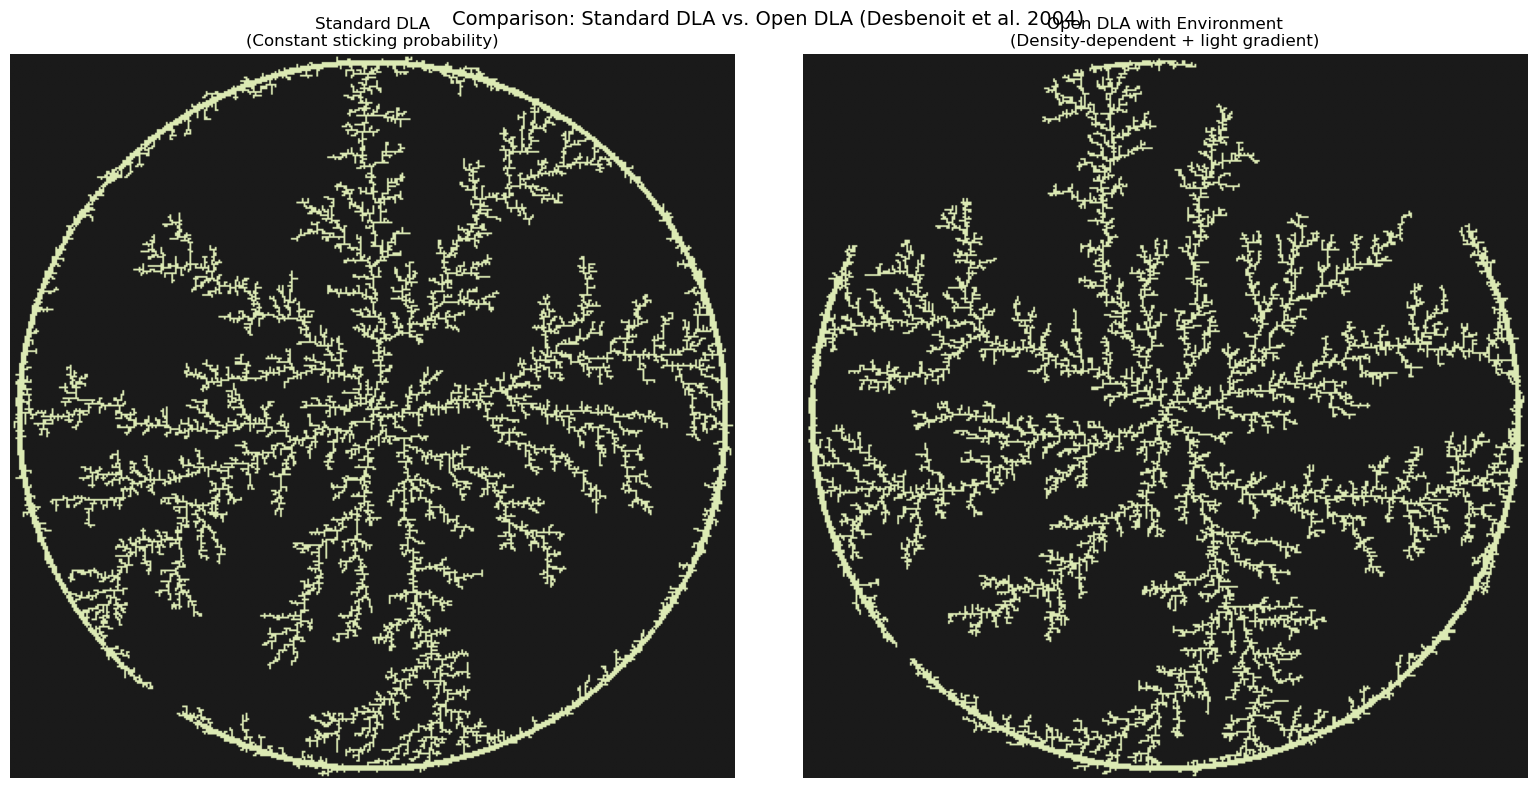


Particle counts:
  Standard DLA: 19,073
  Open DLA:     19,440


In [36]:
@njit
def dla_open_environmental(grid_size, num_particles, max_steps, 
                            alpha=0.3, sigma=0.5, tau=2.5):
    """
    Open DLA with environmental constraints (Desbenoit et al. 2004).
    
    Incorporates aggregation function based on neighbor density and
    environment function based on position (simulating light gradient).
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    alpha : float
        Baseline aggregation probability (0-1)
    sigma : float
        Sensitivity to neighbor density
    tau : float
        Target neighbor count for optimal aggregation
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central seed
    grid[center, center] = 1
    
    particles_added = 0
    max_radius = 1
    
    for _ in range(num_particles * 3):
        if particles_added >= num_particles:
            break
        
        # Spawn on circle
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 15, grid_size // 2 - 5)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Random walk
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            # Count neighbors
            n_neighbors = 0
            if grid[x - 1, y] == 1:
                n_neighbors += 1
            if grid[x + 1, y] == 1:
                n_neighbors += 1
            if grid[x, y - 1] == 1:
                n_neighbors += 1
            if grid[x, y + 1] == 1:
                n_neighbors += 1
            
            if n_neighbors > 0:
                # Aggregation function A(p)
                A = alpha + (1 - alpha) * np.exp(-sigma * (n_neighbors - tau)**2)
                
                # Environment function E(p) - light gradient (higher = more light at top)
                # Simulates lichen preference for certain light conditions
                light = (grid_size - y) / grid_size  # 0 at bottom, 1 at top
                E = 0.5 + 0.5 * light  # Range 0.5-1.0
                
                # Combined probability
                P = E * A
                
                if np.random.rand() < P:
                    grid[x, y] = 1
                    particles_added += 1
                    dist = int(np.sqrt((x - center)**2 + (y - center)**2))
                    if dist > max_radius:
                        max_radius = dist
                break
            
            # Kill radius check
            dist = np.sqrt((x - center)**2 + (y - center)**2)
            if dist > spawn_radius + 20:
                break
    
    return grid


# Run Open DLA simulation
print("Simulating Open DLA with environmental constraints...")
open_dla_grid = dla_open_environmental(
    grid_size=400,
    num_particles=50000,
    max_steps=100000,
    alpha=0.3,
    sigma=0.5,
    tau=2.5
)
print("Simulation complete!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Standard DLA for comparison
standard_dla = dla_lichen(grid_size=400, num_particles=50000, max_steps=100000, sticking_prob=1.0)

axes[0].imshow(standard_dla.T, cmap=lichen_cmap, origin='lower')
axes[0].set_title('Standard DLA\n(Constant sticking probability)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(open_dla_grid.T, cmap=lichen_cmap, origin='lower')
axes[1].set_title('Open DLA with Environment\n(Density-dependent + light gradient)', fontsize=12)
axes[1].axis('off')

plt.suptitle('Comparison: Standard DLA vs. Open DLA (Desbenoit et al. 2004)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nParticle counts:")
print(f"  Standard DLA: {int(np.sum(standard_dla)):,}")
print(f"  Open DLA:     {int(np.sum(open_dla_grid)):,}")

---

## Interactive DLA Explorer

Use the sliders below to experiment with different DLA parameters and see how they affect the resulting structures.

In [37]:
@njit
def dla_interactive(grid_size, num_particles, max_steps, sticking_prob, bias_type):
    """
    Interactive DLA simulation with configurable bias.
    
    bias_type: 0=radial (lichen), 1=upward (bryophyte), 2=tidal flat (stromatolite)
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Set up seed based on bias type
    if bias_type == 0:  # Radial
        grid[center, center] = 1
    elif bias_type == 1:  # Upward (bryophyte)
        for x in range(center - 10, center + 10):
            grid[x, grid_size - 1] = 1
    else:  # Tidal flat (stromatolite) - random elliptical seeds
        n_seeds = 5
        for _ in range(n_seeds):
            cx = np.random.randint(grid_size // 4, 3 * grid_size // 4)
            cy = np.random.randint(grid_size // 4, 3 * grid_size // 4)
            rx = np.random.randint(5, 12)
            ry = np.random.randint(4, rx)
            for dx in range(-rx, rx + 1):
                for dy in range(-ry, ry + 1):
                    if (dx * dx) / (rx * rx + 0.1) + (dy * dy) / (ry * ry + 0.1) <= 1.0:
                        x, y = cx + dx, cy + dy
                        if 0 < x < grid_size - 1 and 0 < y < grid_size - 1:
                            grid[x, y] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 3):
        if particles_added >= num_particles:
            break
        
        # Spawn position based on bias type
        if bias_type == 0:  # Radial
            angle = 2 * np.pi * np.random.rand()
            x = int(center + (grid_size // 2 - 10) * np.cos(angle))
            y = int(center + (grid_size // 2 - 10) * np.sin(angle))
        elif bias_type == 1:  # Upward
            x = np.random.randint(center - grid_size // 3, center + grid_size // 3)
            y = grid_size - 1
        else:  # Tidal flat - spawn from edges
            edge = np.random.randint(4)
            if edge == 0:
                x, y = np.random.randint(0, grid_size), 0
            elif edge == 1:
                x, y = np.random.randint(0, grid_size), grid_size - 1
            elif edge == 2:
                x, y = 0, np.random.randint(0, grid_size)
            else:
                x, y = grid_size - 1, np.random.randint(0, grid_size)
        
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Movement based on bias type
            prob = np.random.rand()
            if bias_type == 0:  # Radial (unbiased)
                direction = np.random.randint(4)
                if direction == 0:
                    x = max(x - 1, 1)
                elif direction == 1:
                    x = min(x + 1, grid_size - 2)
                elif direction == 2:
                    y = max(y - 1, 1)
                else:
                    y = min(y + 1, grid_size - 2)
            elif bias_type == 1:  # Upward
                if prob < 0.55:
                    y = max(y - 1, 1)
                elif prob < 0.75:
                    x = max(x - 1, 1)
                elif prob < 0.95:
                    x = min(x + 1, grid_size - 2)
                else:
                    y = min(y + 1, grid_size - 2)
            else:  # Tidal flat - isotropic
                direction = np.random.randint(4)
                if direction == 0:
                    x = max(x - 1, 1)
                elif direction == 1:
                    x = min(x + 1, grid_size - 2)
                elif direction == 2:
                    y = max(y - 1, 1)
                else:
                    y = min(y + 1, grid_size - 2)
            
            # Check adjacency
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid


def plot_interactive_dla(grid_size, num_particles, sticking_prob, growth_type):
    """Plot DLA with interactive parameters."""
    bias_map = {'Lichen (Radial)': 0, 'Bryophyte (Upward)': 1, 'Stromatolite (Tidal Flat)': 2}
    cmap_map = {'Lichen (Radial)': lichen_cmap, 'Bryophyte (Upward)': bryophyte_cmap, 
                'Stromatolite (Tidal Flat)': stromatolite_cmap}
    
    grid = dla_interactive(grid_size, num_particles, 50000, sticking_prob, bias_map[growth_type])
    
    plt.figure(figsize=(10, 10))
    # For stromatolite, don't transpose (top-down view)
    if growth_type == 'Stromatolite (Tidal Flat)':
        plt.imshow(grid, cmap=cmap_map[growth_type], origin='lower')
    else:
        plt.imshow(grid.T, cmap=cmap_map[growth_type], origin='lower')
    plt.title(f'{growth_type}\nGrid: {grid_size}, Particles: {num_particles}, Sticking: {sticking_prob:.2f}')
    plt.axis('off')
    plt.show()


# Create interactive widget
interact(
    plot_interactive_dla,
    grid_size=widgets.IntSlider(min=100, max=400, step=50, value=200, description='Grid Size'),
    num_particles=widgets.IntSlider(min=5000, max=50000, step=5000, value=20000, description='Particles'),
    sticking_prob=widgets.FloatSlider(min=0.2, max=1.0, step=0.1, value=0.6, description='Sticking Prob'),
    growth_type=widgets.Dropdown(
        options=['Lichen (Radial)', 'Bryophyte (Upward)', 'Stromatolite (Tidal Flat)'],
        value='Lichen (Radial)',
        description='Type'
    )
);

interactive(children=(IntSlider(value=200, description='Grid Size', max=400, min=100, step=50), IntSlider(valu…

---

## 3D Visualization with Plotly

Let's visualize the lichen DLA structure as a 3D surface where height represents particle density.

In [38]:
# Create a 3D visualization without scipy dependency
# Using simple averaging for smoothing instead of gaussian_filter

def simple_smooth(grid, window=3):
    """Simple box blur smoothing without scipy."""
    result = np.zeros_like(grid, dtype=float)
    h, w = grid.shape
    half = window // 2
    
    for i in range(h):
        for j in range(w):
            count = 0
            total = 0.0
            for di in range(-half, half + 1):
                for dj in range(-half, half + 1):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < h and 0 <= nj < w:
                        total += grid[ni, nj]
                        count += 1
            result[i, j] = total / count if count > 0 else 0
    return result

# Downsample for visualization
downsample = 4
lichen_small = lichen_grid[::downsample, ::downsample]

# Apply simple smoothing
lichen_smooth = simple_smooth(lichen_small.astype(float), window=3)

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=lichen_smooth,
    colorscale='Greens',
    showscale=False
)])

fig.update_layout(
    title='3D Visualization of Lichen DLA Structure<br><sub>Height represents particle presence</sub>',
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Density',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    )
)

fig.show()

---

## Summary

In this notebook, we explored **Diffusion Limited Aggregation (DLA)** as a model for understanding natural fractal growth patterns. We demonstrated how simple modifications to the basic DLA algorithm can simulate diverse biological structures:

| Organism | Growth Pattern | Key Parameters | Fractal Character |
|----------|---------------|----------------|------------------|
| **Stromatolite** | Layered, dome-like | Downward bias, horizontal seed | Stacked, branching columns |
| **Bryophyte** | Branching, vertical | Upward bias, low sticking | Dendritic, tree-like |
| **Lichen** | Radial, spreading | Isotropic, central seed | Classic DLA dendrites |

### Key Takeaways

1. **Simple rules create complexity**: DLA demonstrates how complex fractal structures emerge from simple random processes
2. **Bias shapes structure**: Directional biases in random walks dramatically change the resulting morphology
3. **Sticking probability controls branching**: Lower sticking probabilities create more branched, penetrating structures
4. **Universal patterns**: Despite different biology, many natural structures share underlying DLA-like growth mechanisms

### Further Exploration

Try modifying the simulations to explore:
- Multiple seed points (colony formation)
- Time-varying parameters (changing environmental conditions)
- 3D DLA simulations
- Adding nutrients or resource gradients

---

## References

### Foundational DLA Papers

1. Witten, T. A., & Sander, L. M. (1981). Diffusion-Limited Aggregation, a Kinetic Critical Phenomenon. *Physical Review Letters*, 47(19), 1400-1403.

2. Witten, T. A., & Sander, L. M. (1983). Diffusion-Limited Aggregation. *Physical Review B*, 27, 5686-5697.

3. Niemeyer, L., Pietronero, L., & Wiesmann, H. J. (1984). Fractal Dimension of Dielectric Breakdown. *Physical Review Letters*, 52, 1033-1036.

4. Meakin, P. (1998). *Fractals, Scaling and Growth Far from Equilibrium*. Cambridge University Press.

### L-systems and Algorithmic Botany

5. Lindenmayer, A. (1968). Mathematical Models for Cellular Interaction in Development. *Journal of Theoretical Biology*, 18, 280-315.

6. Prusinkiewicz, P., & Lindenmayer, A. (1990). *The Algorithmic Beauty of Plants*. Springer-Verlag. (Free at algorithmicbotany.org)

7. Prusinkiewicz, P., Cieslak, M., Ferraro, P., & Hanan, J. (2018). Modeling Plant Development with L-Systems. In *Mathematical Modelling in Plant Biology*, Springer.

### Lichen-Specific Computational Models

8. Desbenoit, B., Galin, E., & Akkouche, S. (2004). Simulating and Modeling Lichen Growth. *Computer Graphics Forum*, 23(3), 341-350.

9. Sumner, R. W. (2001). Pattern Formation in Lichen. Ph.D. thesis, MIT.

10. Armstrong, R. A. (1988). Radial growth of Rhizocarpon geographicum on rock surfaces. *Lichenologist*, 20(1), 1-11.

### Lichen Biology and Growth Forms

11. Nash, T. H. (2008). *Lichen Biology* (2nd ed.). Cambridge University Press.

12. Brodo, I. M., Sharnoff, S. D., & Sharnoff, S. (2001). *Lichens of North America*. Yale University Press.

13. [Lichen Growth Forms](https://en.wikipedia.org/wiki/Lichen_growth_forms) - Wikipedia

14. [Lichen Morphology](https://britishlichensociety.org.uk/learning/lichen-morphology) - British Lichen Society

### Biological Growth Patterns

15. Ben-Jacob, E., & Garik, P. (1990). The formation of patterns in non-equilibrium growth. *Nature*, 343(6258), 523-530.

16. Allwood, A. C., et al. (2006). Stromatolite reef from the Early Archaean era of Australia. *Nature*, 441(7094), 714-718.

### Hybrid Approaches

17. Fernández, S. et al. (2018). Hybrid L-Systems–Diffusion Limited Aggregation Schemes. *Physica A: Statistical Mechanics and its Applications*.

18. Merks, R. M. et al. (2004). Polyp Oriented Modelling of Coral Growth. *Journal of Theoretical Biology*, 228(4), 559-576.